# Drifting Models for Generation: A Step-by-Step Tutorial

**Paper:** Generative Modeling via Drifting

This notebook walks you through the core algorithm with hands-on examples:

1. **Part 1: Core Algorithm** — The drifting loss and drift computation
2. **Part 2: Toy 2D** — Visualize dynamics on swiss roll & checkerboard
3. **Part 3: Extensions** — Batched feature loss `[B, F, D]` and patchification utilities
4. **Part 4: MNIST** — Train a generator using patchified drifting loss

**More samples and full results can be found in the paper.**

---

# Install packages

In [1]:
!pip install -q matplotlib numpy torch torchvision tqdm einops

In [2]:
import os
import sys
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Device selection
# - In Colab: prefer CUDA (GPU) and warn if GPU isn't enabled
# - Locally: prefer CUDA, then Apple Silicon MPS, then CPU
IN_COLAB = (
    "google.colab" in sys.modules
    or os.environ.get("COLAB_GPU") is not None
    or os.environ.get("COLAB_TPU_ADDR") is not None
)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif (not IN_COLAB) and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE} (IN_COLAB={IN_COLAB})")
if IN_COLAB and DEVICE.type != "cuda":
    print(
        "[Warning] Colab 当前没有启用 GPU。请在菜单 Runtime -> Change runtime type -> GPU 后重新运行此 cell。"
    )

Using device: mps (IN_COLAB=False)


/opt/homebrew/Caskroom/miniforge/base/envs/mar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Core Concept

**Traditional generative models** (Diffusion, Flow Matching) iterate at **inference time**.

**Drifting Models** move the iteration to **training time**:
- Each training step "drifts" the generated samples, according to a drifting field
- At inference: just one forward pass (1 NFE)

### Training Objective

Given a generator $f_\theta$ that maps noise $\epsilon$ to samples, the training loss is:

$$\mathcal{L} = \mathbb{E}_{\epsilon} \left[ \| f_\theta(\epsilon) - \text{stopgrad}(f_\theta(\epsilon) + \mathbf{V}_{p,q}(f_\theta(\epsilon))) \|^2 \right]$$

We move predictions toward their **drifted** versions. The drifting field $\mathbf{V}_{p,q}$, depending on the data distribution $p$ and the generated distribution $q$, tells each generated sample where to go.

### The Drifting Field

A wide range of drifting field $\mathbf{V}_{p,q}$ will be valid, as long as $\mathbf{V}_{p,p}=\mathbf 0$: this guarantees the training reaches equilibrium when the distributions match. 

As in the paper, we use a drifting field inspired by mean-shift in the code below, computing $\mathbf{V}_{p,q}(\mathbf x)=\mathbb E_{\mathbf y+,\mathbf y-}[]$

---

# Part 1: Core Algorithm

First, let's implement the core building blocks:
1. `drifting_loss` — The training objective
2. `compute_drift` — The drifting field $\mathbf{V}$

In [3]:
# ============================================================
# Core: Compute Drift V and Loss (from toy_mean_drift.py)
# ============================================================

def compute_drift(gen: torch.Tensor, pos: torch.Tensor, temp: float = 0.05):
    """
    Compute drift field V with attention-based kernel.
    
    Args:
        gen: Generated samples [G, D]
        pos: Data samples [P, D]
        temp: Temperature for softmax kernel
    
    Returns:
        V: Drift vectors [G, D]
    """
    targets = torch.cat([gen, pos], dim=0)
    G = gen.shape[0]

    dist = torch.cdist(gen, targets)
    dist[:, :G].fill_diagonal_(1e6)  # mask self

    # attention kernel (row & col softmax)
    kernel = (-dist / temp).softmax(dim=-1)
    kernel = (kernel * (-dist / temp).softmax(dim=-2)).clamp_min(0).sqrt()

    # drift coefficients: V = sum(w_pos * pos) - sum(w_neg * gen)
    w_pos = kernel[:, G:] * kernel[:, :G].sum(dim=-1, keepdim=True)
    w_neg = kernel[:, :G] * kernel[:, G:].sum(dim=-1, keepdim=True)
    drift_coeff = torch.cat([-w_neg, w_pos], dim=1)

    return drift_coeff @ targets


def drifting_loss(gen: torch.Tensor, pos: torch.Tensor, temp: float = 0.05):
    """Drifting loss: MSE(gen, stopgrad(gen + V))."""
    with torch.no_grad():
        V = compute_drift(gen, pos, temp)
        target = (gen + V).detach()
    return F.mse_loss(gen, target), V.pow(2).mean().item()


### Visualize the Drift Field

Let's see what the drift vectors look like on some random points.

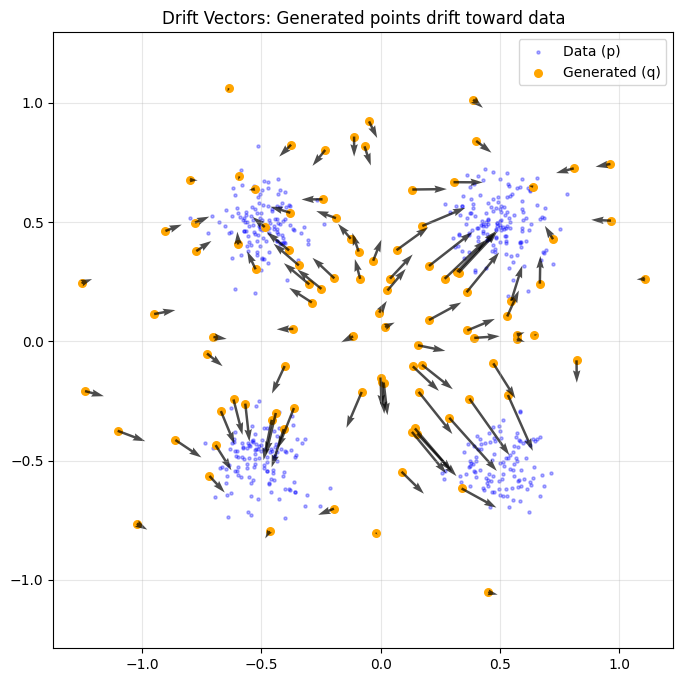

In [4]:
# Quick visualization of drift vectors
torch.manual_seed(42)

# Random generated points (from Gaussian)
gen_test = torch.randn(100, 2) * 0.5

# Target data: simple 4-mode Gaussian mixture
centers = torch.tensor([[-0.5, -0.5], [-0.5, 0.5], [0.5, -0.5], [0.5, 0.5]])
idx = torch.randint(0, 4, (500,))
pos_test = centers[idx] + torch.randn(500, 2) * 0.1

# Compute drift
drift_test = compute_drift(gen_test, pos_test, temp=0.2)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(pos_test[:, 0], pos_test[:, 1], s=5, alpha=0.3, c='blue', label='Data (p)')
plt.scatter(gen_test[:, 0], gen_test[:, 1], s=30, c='orange', label='Generated (q)')
plt.quiver(gen_test[:, 0], gen_test[:, 1], drift_test[:, 0], drift_test[:, 1],
           scale=3, color='black', alpha=0.7, width=0.004)
plt.legend()
plt.title('Drift Vectors: Generated points drift toward data')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

---

# Part 2: Toy 2D Examples

Let's train on 2D distributions to visualize the full training dynamics.

We'll use two classic test distributions:
- **Checkerboard**: 4 diagonally-arranged squares (tests mode coverage)
- **Swiss Roll**: Spiral pattern (tests learning complex geometry)

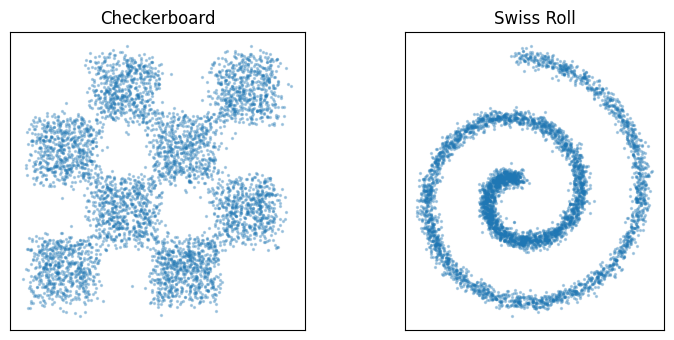

In [5]:
# ============================================================
# Toy Dataset Samplers (minimal; copied from toy_mean_drift.py)
# ============================================================

def sample_checkerboard(n: int, noise: float = 0.05, seed: int | None = None) -> torch.Tensor:
    g = torch.Generator().manual_seed(seed) if seed is not None else None
    b = torch.randint(0, 2, (n,), generator=g)
    i = torch.randint(0, 2, (n,), generator=g) * 2 + b
    j = torch.randint(0, 2, (n,), generator=g) * 2 + b
    u = torch.rand(n, generator=g)
    v = torch.rand(n, generator=g)
    pts = torch.stack([i + u, j + v], dim=1) - 2.0
    pts = pts / 2.0
    if noise > 0:
        pts = pts + noise * torch.randn(pts.shape, generator=g)
    return pts


def sample_swiss_roll(n: int, noise: float = 0.03, seed: int | None = None) -> torch.Tensor:
    g = torch.Generator().manual_seed(seed) if seed is not None else None
    u = torch.rand(n, generator=g)
    t = 0.5 * math.pi + 4.0 * math.pi * u
    pts = torch.stack([t * torch.cos(t), t * torch.sin(t)], dim=1)
    pts = pts / (pts.abs().max() + 1e-8)
    if noise > 0:
        pts = pts + noise * torch.randn(pts.shape, generator=g)
    return pts


# quick look
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
for ax, (name, sampler) in zip(axes, [("Checkerboard", sample_checkerboard), ("Swiss Roll", sample_swiss_roll)]):
    pts = sampler(5000).numpy()
    ax.scatter(pts[:, 0], pts[:, 1], s=2, alpha=0.3)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [6]:
# ============================================================
# Training Loop for Toy 2D
# ============================================================
class MLP(nn.Module):
    """MLP: noise -> output. 3 hidden layers with SiLU."""
    def __init__(self, in_dim=32, hidden=256, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, z):
        return self.net(z)

def train_toy(sampler, steps=2000, data_batch_size=2048, gen_batch_size=2048, lr=1e-3, temp=0.05,
              in_dim=32, hidden=256, plot_every=500, seed=42):
    """Train drifting model. Shows EMA loss in tqdm, plots every `plot_every` steps."""
    torch.manual_seed(seed)
    model = MLP(in_dim=in_dim, hidden=hidden, out_dim=2).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    ema = None
    pbar = tqdm(range(1, steps + 1))
    for step in pbar:
        pos = sampler(data_batch_size).to(DEVICE)
        gen = model(torch.randn(gen_batch_size, in_dim, device=DEVICE))
        loss, drift_norm = drifting_loss(gen, pos, temp=temp)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        ema = loss.item() if ema is None else 0.96 * ema + 0.04 * loss.item()
        pbar.set_postfix(loss=f"{ema:.2e}")
        
        if step % plot_every == 0 or step == 1:
            with torch.no_grad():
                vis = model(torch.randn(5000, in_dim, device=DEVICE)).cpu().numpy()
                gt = sampler(5000).numpy()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
            ax1.scatter(gt[:, 0], gt[:, 1], s=2, alpha=0.3, c='black')
            ax1.set_title('Target'); ax1.set_aspect('equal'); ax1.axis('off')
            ax2.scatter(vis[:, 0], vis[:, 1], s=2, alpha=0.3, c='tab:orange')
            ax2.set_title(f'Generated (step {step})'); ax2.set_aspect('equal'); ax2.axis('off')
            plt.tight_layout(); plt.show()
    
    return model

Training on Swiss Roll...


  0%|          | 0/2000 [00:00<?, ?it/s, loss=7.46e-06]

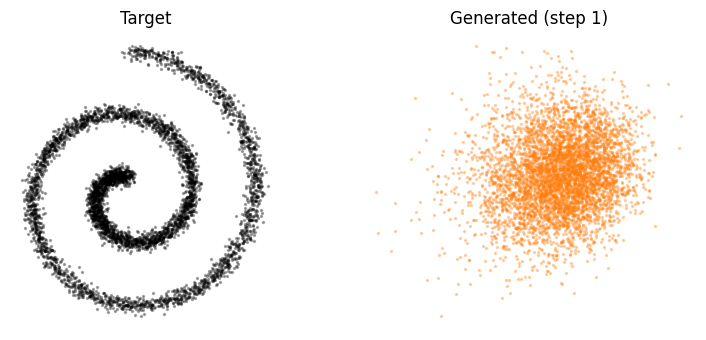

 25%|██▍       | 493/2000 [00:04<00:12, 119.95it/s, loss=2.95e-04]

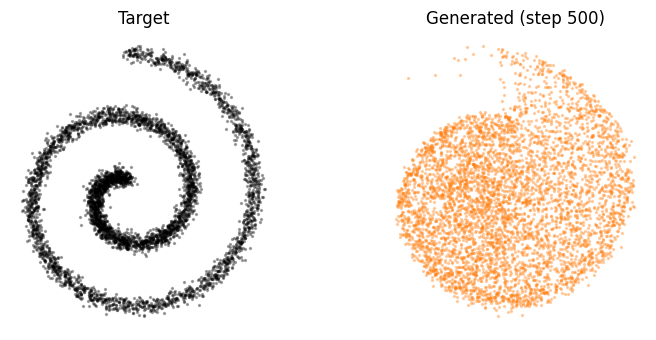

 50%|████▉     | 995/2000 [00:07<00:07, 127.83it/s, loss=4.20e-05]

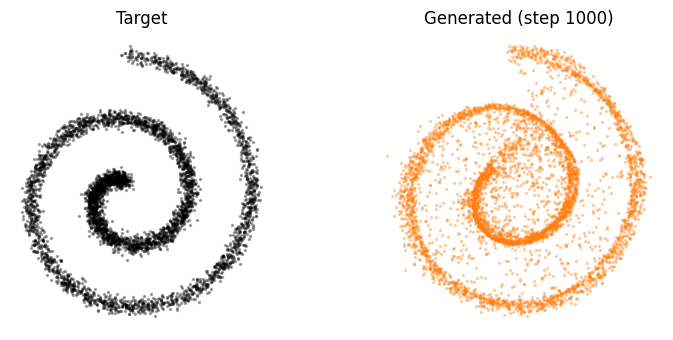

 74%|███████▍  | 1486/2000 [00:11<00:04, 127.15it/s, loss=2.01e-05]

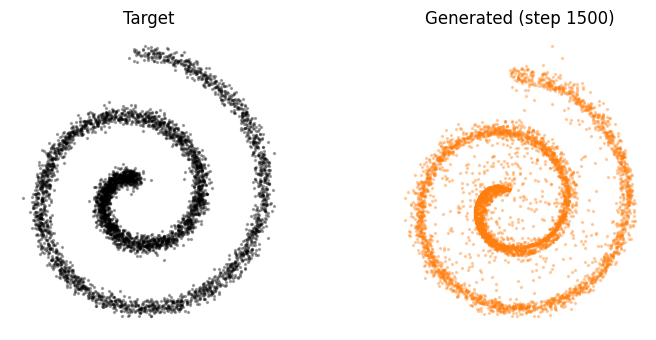

 99%|█████████▉| 1989/2000 [00:15<00:00, 119.65it/s, loss=1.46e-05]

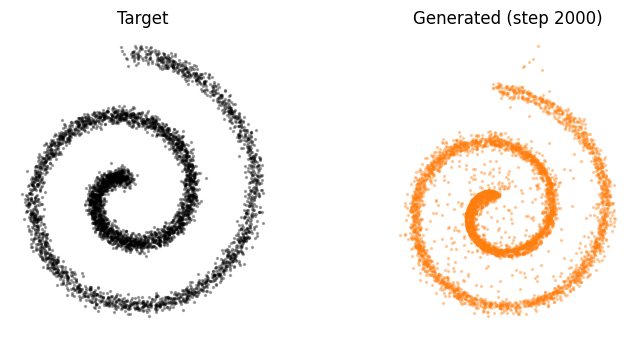

100%|██████████| 2000/2000 [00:15<00:00, 126.02it/s, loss=1.46e-05]



Training on Checkerboard...


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.48e-07]

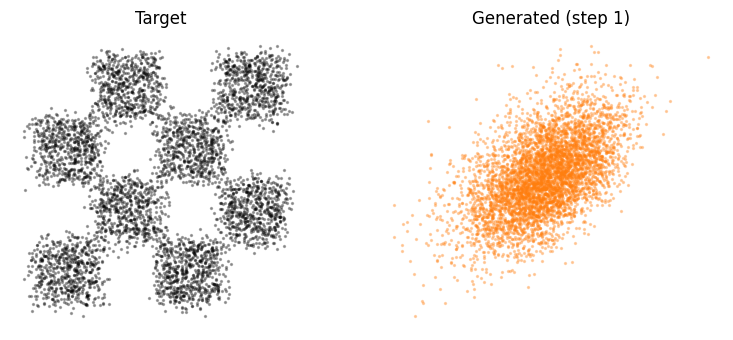

 25%|██▍       | 494/2000 [00:03<00:11, 133.01it/s, loss=1.19e-04]

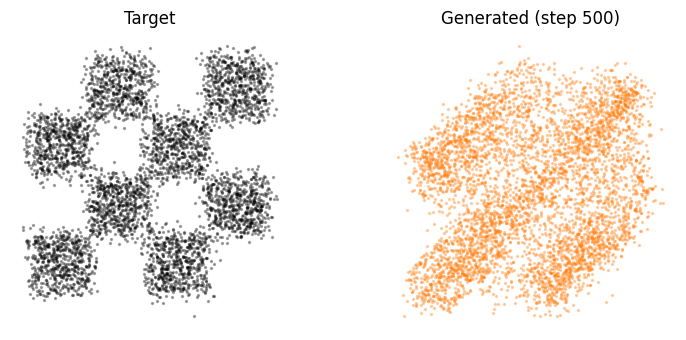

 49%|████▉     | 987/2000 [00:07<00:07, 133.81it/s, loss=4.91e-05]

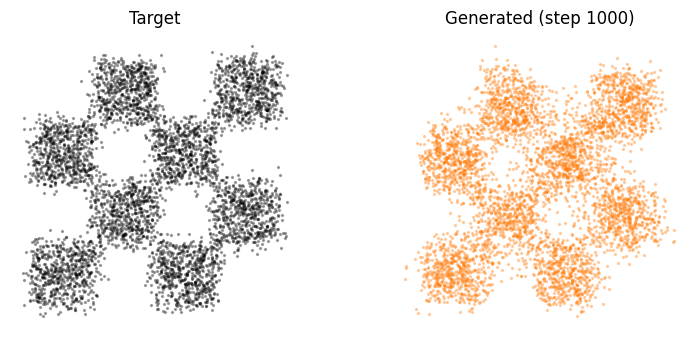

 74%|███████▍  | 1486/2000 [00:11<00:03, 142.47it/s, loss=3.65e-05]

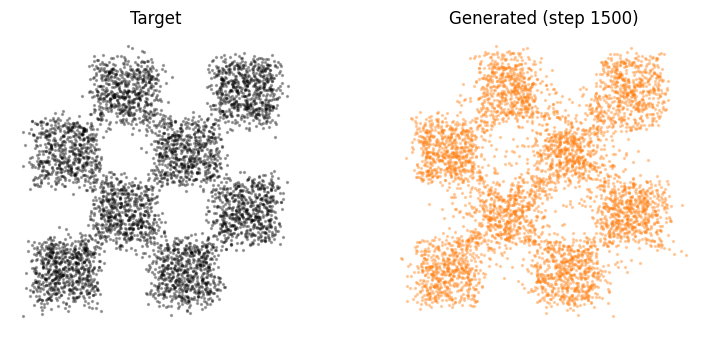

 99%|█████████▉| 1985/2000 [00:15<00:00, 134.27it/s, loss=3.48e-05]

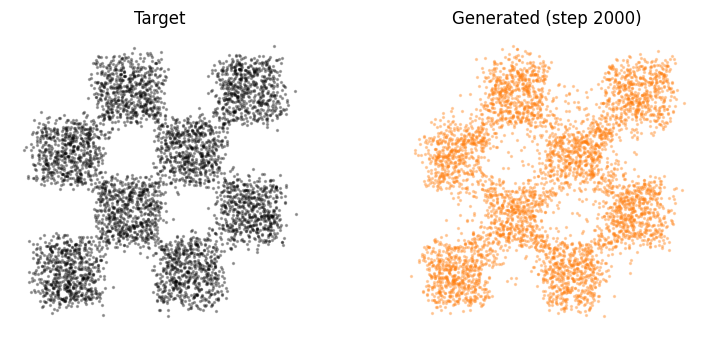

100%|██████████| 2000/2000 [00:15<00:00, 131.74it/s, loss=3.48e-05]


In [7]:
# Train on both datasets (hyperparams from toy_mean_drift.py)
print("Training on Swiss Roll...")
model_swiss = train_toy(sample_swiss_roll, steps=2000, lr=1e-3, temp=0.05)

print("\nTraining on Checkerboard...")
model_checker = train_toy(sample_checkerboard, steps=2000, lr=1e-3, temp=0.05)

# Part 3: Generation on MNIST

Having solved the toy cases, let's apply the method to MNIST!

To accomodate for high dimensionality, we made the following changes to the drifting loss:

(a) The 

(b) To ease the sweeping temperatures, we use multiple tempeartures, and scale the norm of V of each to 1, so no single temperature dominates the training; 

Since data is in $28\times 28=784$ dimensions, the temperature should be scaled to have the same order as average distances. Below, we modify the drifting function to multiply temperature by the average distance between samples

In [8]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Device (supports CUDA, Apple Silicon MPS, or CPU)
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f"Using device: {DEVICE}")

Using device: mps


In [9]:
# ============================================================
# Core: Compute Drift V and Loss (from toy_mean_drift.py)
# ============================================================

def compute_drift(gen: torch.Tensor, pos: torch.Tensor, temps = [0.05, 0.1, 0.2]):
    """
    Compute drift field V with attention-based kernel.
    
    Args:
        gen: Generated samples [G, D]
        pos: Data samples [P, D]
        temp: Temperature for softmax kernel
    
    Returns:
        V: Drift vectors [G, D]
    """
    targets = torch.cat([gen, pos], dim=0)
    G = gen.shape[0]

    dist = torch.cdist(gen, targets)
    mean_scale = (pos ** 2).sum(dim=-1).sqrt().mean()

    info = dict()
    mean_dist = dist.mean()        
    # mean_dist = mean_scale
    info['mean_dist'] = mean_dist
    dist[:, :G].fill_diagonal_(1e6)  # mask self
    total_V = torch.zeros_like(gen)
    for temp in temps:
        scale = temp * mean_dist # Change here: temp should be of the same order as average distance

        kernel = (-dist / scale).softmax(dim=-1)
        kernel = (kernel * (-dist / scale).softmax(dim=-2)).clamp_min(0).sqrt()

        w_pos = kernel[:, G:] * kernel[:, :G].sum(dim=-1, keepdim=True)
        w_neg = kernel[:, :G] * kernel[:, G:].sum(dim=-1, keepdim=True)
        info[f'ratio_{temp}'] = kernel[:, G:].mean() / kernel[:, :G].mean()
        drift_coeff = torch.cat([-w_neg, w_pos], dim=1)
        temp_V = drift_coeff @ targets
        info[f'norm_{temp}'] = (temp_V ** 2).mean().clamp_min(1e-8).sqrt()
        temp_V = temp_V / info[f'norm_{temp}']
        total_V = total_V + temp_V

    return total_V, info


def drifting_loss(gen: torch.Tensor, pos: torch.Tensor, temp = [0.05, 0.1, 0.2]):
    """Drifting loss: MSE(gen, stopgrad(gen + V))."""
    with torch.no_grad():
        V, info = compute_drift(gen, pos, temp)
        target = (gen + V).detach()
    return F.mse_loss(gen, target), V.pow(2).mean().item(), info


In [10]:
# architecture: copied from https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, noise_dim=128, device=None):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.noise_dim = noise_dim
        self.n_feat = n_feat
        self.device = device

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.style_transform = nn.Sequential(
            nn.Linear(self.noise_dim, self.noise_dim),
            nn.SiLU()
        )

        self.cemb1 = EmbedFC(noise_dim, 2*n_feat)
        self.cemb2 = EmbedFC(noise_dim, 1*n_feat)
        self.temb1 = EmbedFC(noise_dim, 2*n_feat)
        self.temb2 = EmbedFC(noise_dim, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )
        self.to(device)

    def generate(self, bsz):
        x = torch.randn(bsz, self.in_channels, 28, 28, device=self.device)
        style = torch.randn(bsz, self.noise_dim, device=self.device)
        style_transformed = self.style_transform(style)
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        # embed style as context and time
        cemb1 = self.cemb1(style_transformed).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.temb1(style_transformed).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.cemb2(style_transformed).view(-1, self.n_feat, 1, 1)
        temb2 = self.temb2(style_transformed).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

class MLP(nn.Module):
    """MLP: noise -> output. 3 hidden layers with SiLU."""
    def __init__(self, in_dim=32, hidden=256, out_dim=2, device=None):
        super().__init__()
        self.in_dim = in_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, out_dim),
        )
        self.device = device
        self.to(device)
    def generate(self, bsz):
        noise = torch.randn(bsz, self.in_dim, device = self.device)
        return self.net(noise).reshape(-1, 1, 28, 28)


Using device: mps


Training:   0%|                                                 | 0/20000 [00:00<?, ?it/s]

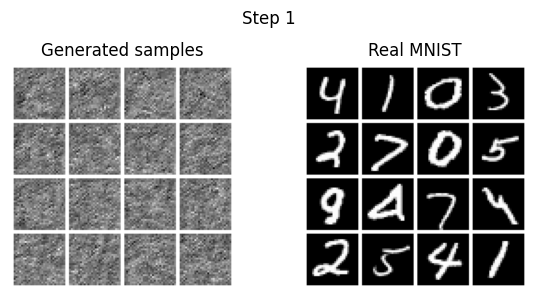

Training:   0%|                                        | 21/20000 [00:03<52:20,  6.36it/s]

Step 20/20000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.7172e+01, ratio_0.2=1.2125e-01, norm_0.2=2.5560e-01; lr=1.60e-05


Training:   0%|                                        | 37/20000 [00:06<56:28,  5.89it/s]


KeyboardInterrupt: 

In [11]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import trange

import torch.nn.utils as nn_utils  # Add this import for gradient clipping
def train_mnist(
    n_feats=32, 
    noise_dim=128,
    batch_size=512,
    gen_batch_size=512,
    steps=20000,                  # Use steps instead of epochs
    plot_interval=500,            # Plot every N steps
    lr=1e-3,
    temp=[0.05, 0.1, 0.2],
    device=None,
    warmup_steps=500,
    log_every=50,
    use_mlp=False,
    grad_clip_norm=1.0,           # <-- add a grad_clip_norm parameter (default 1.0)
):
    # Setup dataset & model
    device = device or ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    data_tensor = mnist_train.data.float() / 255.0
    data_tensor = data_tensor * 2 - 1   # [-1, 1] like normalization above
    data_tensor = data_tensor.unsqueeze(1)  # (N,1,28,28)
    # print(data_tensor.min(), data_tensor.max()) 
    # 
    if use_mlp:
        model = MLP(in_dim=784, hidden=256, out_dim=28*28, device=device)
    else:
        model = ContextUnet(in_channels=1, n_feat=n_feats, noise_dim=noise_dim, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def get_warmup_lr(step, base_lr, warmup_steps):
        if warmup_steps == 0:
            return base_lr
        return base_lr * min(1.0, (step + 1) / warmup_steps)
    
    losses = []
    drift_mags = []

    # Global running EMA for loss/info (not reset per epoch)
    ema_infos = dict()  # key: info key (e.g., norm), value: current ema
    alpha = 0.01        # EMA smoothing for loss and infos
    loss_ema = None     # Not reset per epoch

    # Main training loop, sample random batches from entire MNIST
    num_total = data_tensor.shape[0]

    for step in trange(steps, desc="Training", ncols=90):
        model.train()
        # Randomly sample indices for batch
        idx = np.random.choice(num_total, batch_size, replace=False)
        real_imgs = data_tensor[idx].to(device)   # (B, 1, 28, 28)
        real_imgs = real_imgs.view(-1, 784)
        gen_imgs = model.generate(gen_batch_size).view(-1, 784)
        loss, drift_mag, info = drifting_loss(gen_imgs, real_imgs, temp=temp)
        optimizer.zero_grad()
        loss.backward()

        # ------- Clip gradient norm here -------
        nn_utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
        # ----------------------------------------

        # ---- Learning rate warmup update ----
        warmup_lr = get_warmup_lr(step, lr, warmup_steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] = warmup_lr

        optimizer.step()

        # Keep track of running (not "per epoch") loss and info
        loss_scalar = float(loss.item())
        if loss_ema is None:
            loss_ema = loss_scalar
        else:
            loss_ema = alpha * loss_scalar + (1 - alpha) * loss_ema

        for k, v in info.items():
            v_scalar = float(v.item()) if hasattr(v, 'item') else float(v)
            if k not in ema_infos:
                ema_infos[k] = v_scalar
            else:
                ema_infos[k] = alpha * v_scalar + (1 - alpha) * ema_infos[k]

        # Store every N steps for plotting/inspection
        if (step+1) % plot_interval == 0 or step == 0:
            losses.append(loss_ema)
            drift_mags.append(ema_infos.get("norm_{}".format(temp[0]), 0.0))
            # Print/visualize generated samples for debugging
            model.eval()
            with torch.no_grad():
                fig, axes = plt.subplots(1, 2, figsize=(6, 3))
                # Plot a grid of generated images
                gen_samples = model.generate(16).cpu()
                grid = torchvision.utils.make_grid(gen_samples, nrow=4, normalize=True, pad_value=1)
                axes[0].imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
                axes[0].axis('off')
                axes[0].set_title("Generated samples")
                # Plot a grid of real images for comparison
                real_samples_from_data = data_tensor[idx][:16].cpu()
                real_grid = torchvision.utils.make_grid(real_samples_from_data, nrow=4, normalize=True, pad_value=1)
                axes[1].imshow(real_grid.permute(1, 2, 0).squeeze(), cmap='gray')
                axes[1].axis('off')
                axes[1].set_title("Real MNIST")
                plt.suptitle(f'Step {step+1}')
                plt.tight_layout()
                plt.show()

        if (step+1) % log_every == 0 or step == steps - 1 or (step+1) % plot_interval == 0:
            ema_info_str = ', '.join([f"{k}={v:.4e}" for k, v in ema_infos.items()])
            print(f"Step {step+1}/{steps}: EMA Loss={loss_ema:.4e}; EMA infos: {ema_info_str}; lr={warmup_lr:.2e}")

    # Plot loss and drift magnitude curves over time
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(losses))*plot_interval, losses, label="Running EMA Loss")
    plt.xlabel('Step')
    plt.ylabel('Loss (EMA, MSE)')
    plt.title('Drifting Loss')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(drift_mags))*plot_interval, drift_mags, label="EMA Drift Magnitude", color='orange')
    plt.xlabel('Step')
    plt.ylabel('Drift² (EMA)')
    plt.title('Drift Vector Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, losses, drift_mags

# Example usage:
# model, losses, drift_mags = train_mnist(steps=10000)

model, losses, drift_mags = train_mnist(
    steps=20000,
    temp=[0.2],
    lr=4e-4,
    batch_size=2048,
    gen_batch_size=1024,
    warmup_steps=500,
    plot_interval=100,
    use_mlp=False, 
    log_every=20,
    grad_clip_norm=1.0     # explicitly set clip norm, or adjust as desired
)

Using device: mps


Training:   0%|                                                 | 0/10000 [00:00<?, ?it/s]

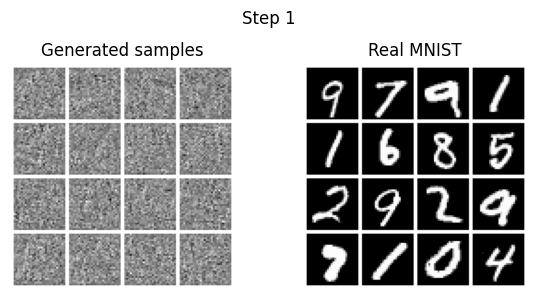

Training:   0%|                                      | 20/10000 [00:09<1:10:49,  2.35it/s]

Step 20/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.3100e+01, ratio_0.2=1.4283e-01, norm_0.2=2.3397e-01; lr=1.60e-05


Training:   0%|▏                                     | 40/10000 [00:18<1:10:19,  2.36it/s]

Step 40/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.1943e+01, ratio_0.2=1.6683e-01, norm_0.2=2.2312e-01; lr=3.20e-05


Training:   1%|▏                                     | 60/10000 [00:26<1:11:40,  2.31it/s]

Step 60/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.1004e+01, ratio_0.2=2.2942e-01, norm_0.2=2.0633e-01; lr=4.80e-05


Training:   1%|▎                                     | 80/10000 [00:35<1:11:43,  2.31it/s]

Step 80/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0221e+01, ratio_0.2=2.9808e-01, norm_0.2=1.8137e-01; lr=6.40e-05


Training:   1%|▍                                     | 99/10000 [00:43<1:13:26,  2.25it/s]

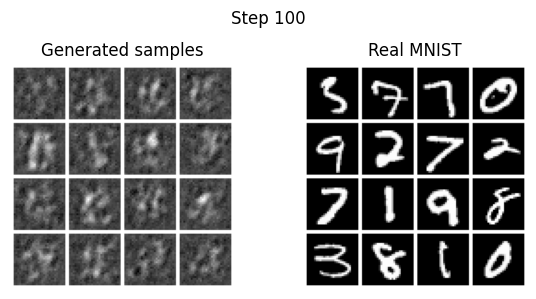

Training:   1%|▎                                    | 100/10000 [00:44<1:16:18,  2.16it/s]

Step 100/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0217e+01, ratio_0.2=4.2179e-01, norm_0.2=1.5641e-01; lr=8.00e-05


Training:   1%|▍                                    | 120/10000 [00:53<1:14:09,  2.22it/s]

Step 120/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0283e+01, ratio_0.2=5.3073e-01, norm_0.2=1.3396e-01; lr=9.60e-05


Training:   1%|▌                                    | 140/10000 [01:02<1:15:21,  2.18it/s]

Step 140/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0333e+01, ratio_0.2=6.2004e-01, norm_0.2=1.1437e-01; lr=1.12e-04


Training:   2%|▌                                    | 160/10000 [01:11<1:14:57,  2.19it/s]

Step 160/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0405e+01, ratio_0.2=6.9659e-01, norm_0.2=9.8419e-02; lr=1.28e-04


Training:   2%|▋                                    | 180/10000 [01:20<1:14:15,  2.20it/s]

Step 180/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0487e+01, ratio_0.2=7.6159e-01, norm_0.2=8.4759e-02; lr=1.44e-04


Training:   2%|▋                                    | 199/10000 [01:29<1:13:00,  2.24it/s]

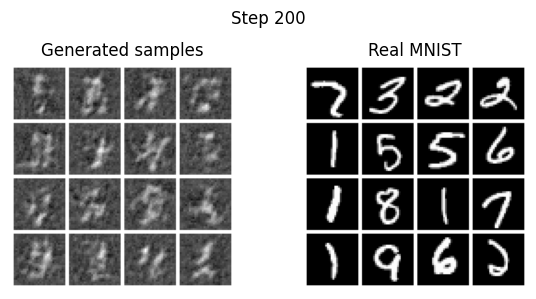

Training:   2%|▋                                    | 200/10000 [01:29<1:15:23,  2.17it/s]

Step 200/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0576e+01, ratio_0.2=8.1633e-01, norm_0.2=7.4228e-02; lr=1.60e-04


Training:   2%|▊                                    | 220/10000 [01:38<1:11:53,  2.27it/s]

Step 220/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0672e+01, ratio_0.2=8.6266e-01, norm_0.2=6.5390e-02; lr=1.76e-04


Training:   2%|▉                                    | 240/10000 [01:47<1:13:52,  2.20it/s]

Step 240/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0742e+01, ratio_0.2=8.9980e-01, norm_0.2=5.7743e-02; lr=1.92e-04


Training:   3%|▉                                    | 260/10000 [01:56<1:14:12,  2.19it/s]

Step 260/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0813e+01, ratio_0.2=9.3166e-01, norm_0.2=5.1661e-02; lr=2.08e-04


Training:   3%|█                                    | 280/10000 [02:05<1:13:36,  2.20it/s]

Step 280/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0831e+01, ratio_0.2=9.5401e-01, norm_0.2=4.7382e-02; lr=2.24e-04


Training:   3%|█                                    | 299/10000 [02:14<1:20:38,  2.00it/s]

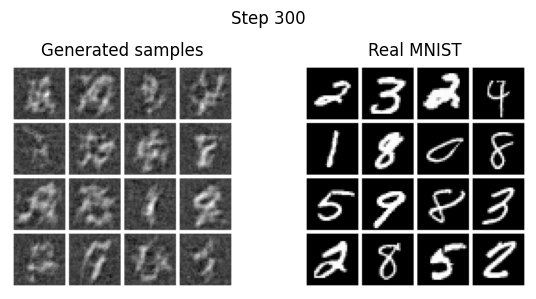

Training:   3%|█                                    | 300/10000 [02:15<1:23:10,  1.94it/s]

Step 300/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0867e+01, ratio_0.2=9.7404e-01, norm_0.2=4.3863e-02; lr=2.40e-04


Training:   3%|█▏                                   | 320/10000 [02:25<1:23:52,  1.92it/s]

Step 320/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0893e+01, ratio_0.2=9.9028e-01, norm_0.2=3.9988e-02; lr=2.56e-04


Training:   3%|█▎                                   | 340/10000 [02:36<1:27:37,  1.84it/s]

Step 340/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0916e+01, ratio_0.2=1.0033e+00, norm_0.2=3.7900e-02; lr=2.72e-04


Training:   4%|█▎                                   | 360/10000 [02:47<1:30:17,  1.78it/s]

Step 360/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0895e+01, ratio_0.2=1.0100e+00, norm_0.2=3.7066e-02; lr=2.88e-04


Training:   4%|█▍                                   | 380/10000 [02:58<1:29:25,  1.79it/s]

Step 380/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0890e+01, ratio_0.2=1.0170e+00, norm_0.2=3.5042e-02; lr=3.04e-04


Training:   4%|█▍                                   | 399/10000 [03:09<1:30:18,  1.77it/s]

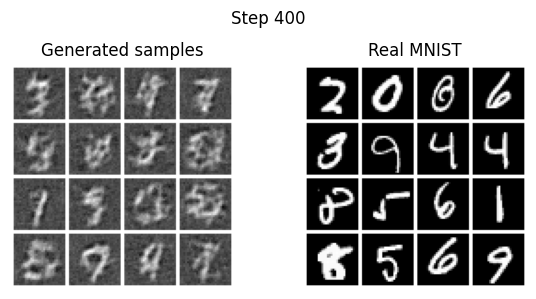

Training:   4%|█▍                                   | 400/10000 [03:10<1:32:37,  1.73it/s]

Step 400/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0872e+01, ratio_0.2=1.0215e+00, norm_0.2=3.3602e-02; lr=3.20e-04


Training:   4%|█▌                                   | 420/10000 [03:21<1:33:35,  1.71it/s]

Step 420/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0865e+01, ratio_0.2=1.0258e+00, norm_0.2=3.2609e-02; lr=3.36e-04


Training:   4%|█▋                                   | 440/10000 [03:33<1:32:31,  1.72it/s]

Step 440/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0833e+01, ratio_0.2=1.0273e+00, norm_0.2=3.1311e-02; lr=3.52e-04


Training:   5%|█▋                                   | 460/10000 [03:45<1:38:46,  1.61it/s]

Step 460/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0847e+01, ratio_0.2=1.0310e+00, norm_0.2=3.0766e-02; lr=3.68e-04


Training:   5%|█▊                                   | 480/10000 [03:58<1:40:45,  1.57it/s]

Step 480/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0810e+01, ratio_0.2=1.0302e+00, norm_0.2=3.0073e-02; lr=3.84e-04


Training:   5%|█▊                                   | 499/10000 [04:09<1:28:47,  1.78it/s]

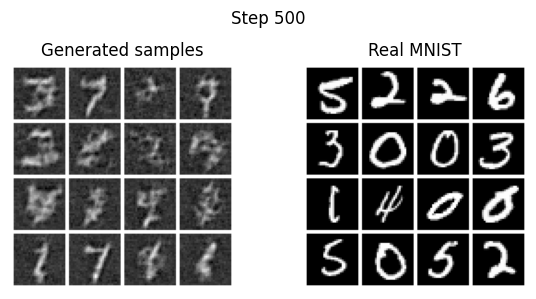

Training:   5%|█▊                                   | 500/10000 [04:09<1:30:49,  1.74it/s]

Step 500/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0811e+01, ratio_0.2=1.0323e+00, norm_0.2=2.9611e-02; lr=4.00e-04


Training:   5%|█▉                                   | 520/10000 [04:20<1:27:06,  1.81it/s]

Step 520/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0767e+01, ratio_0.2=1.0306e+00, norm_0.2=2.8797e-02; lr=4.00e-04


Training:   5%|█▉                                   | 540/10000 [04:31<1:26:25,  1.82it/s]

Step 540/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0746e+01, ratio_0.2=1.0302e+00, norm_0.2=2.7928e-02; lr=4.00e-04


Training:   6%|██                                   | 560/10000 [04:43<1:32:16,  1.70it/s]

Step 560/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0714e+01, ratio_0.2=1.0281e+00, norm_0.2=2.7398e-02; lr=4.00e-04


Training:   6%|██▏                                  | 580/10000 [04:54<1:25:48,  1.83it/s]

Step 580/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0688e+01, ratio_0.2=1.0270e+00, norm_0.2=2.7501e-02; lr=4.00e-04


Training:   6%|██▏                                  | 599/10000 [05:05<1:25:40,  1.83it/s]

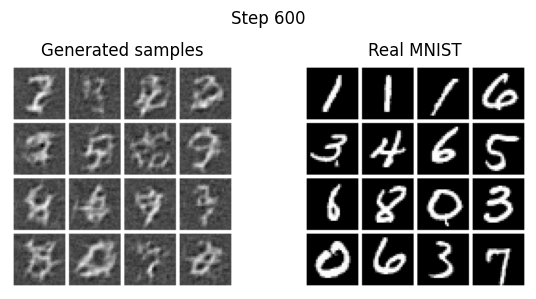

Training:   6%|██▏                                  | 600/10000 [05:05<1:27:10,  1.80it/s]

Step 600/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0671e+01, ratio_0.2=1.0261e+00, norm_0.2=2.7554e-02; lr=4.00e-04


Training:   6%|██▎                                  | 620/10000 [05:16<1:27:59,  1.78it/s]

Step 620/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0630e+01, ratio_0.2=1.0228e+00, norm_0.2=2.7607e-02; lr=4.00e-04


Training:   6%|██▎                                  | 640/10000 [05:27<1:27:23,  1.79it/s]

Step 640/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0602e+01, ratio_0.2=1.0214e+00, norm_0.2=2.7136e-02; lr=4.00e-04


Training:   7%|██▍                                  | 660/10000 [05:39<1:24:16,  1.85it/s]

Step 660/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0581e+01, ratio_0.2=1.0203e+00, norm_0.2=2.6969e-02; lr=4.00e-04


Training:   7%|██▌                                  | 680/10000 [05:50<1:21:08,  1.91it/s]

Step 680/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0571e+01, ratio_0.2=1.0202e+00, norm_0.2=2.6168e-02; lr=4.00e-04


Training:   7%|██▌                                  | 699/10000 [06:00<1:21:31,  1.90it/s]

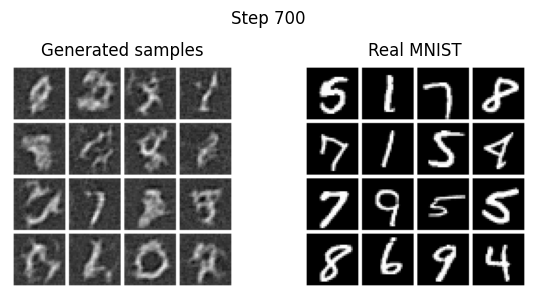

Training:   7%|██▌                                  | 700/10000 [06:00<1:23:34,  1.85it/s]

Step 700/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0559e+01, ratio_0.2=1.0192e+00, norm_0.2=2.6861e-02; lr=4.00e-04


Training:   7%|██▋                                  | 720/10000 [06:11<1:27:06,  1.78it/s]

Step 720/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0515e+01, ratio_0.2=1.0159e+00, norm_0.2=2.6779e-02; lr=4.00e-04


Training:   7%|██▋                                  | 740/10000 [06:22<1:22:16,  1.88it/s]

Step 740/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0517e+01, ratio_0.2=1.0160e+00, norm_0.2=2.6513e-02; lr=4.00e-04


Training:   8%|██▊                                  | 760/10000 [06:33<1:21:26,  1.89it/s]

Step 760/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0492e+01, ratio_0.2=1.0142e+00, norm_0.2=2.5895e-02; lr=4.00e-04


Training:   8%|██▉                                  | 780/10000 [06:43<1:23:24,  1.84it/s]

Step 780/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0486e+01, ratio_0.2=1.0139e+00, norm_0.2=2.5830e-02; lr=4.00e-04


Training:   8%|██▉                                  | 799/10000 [06:54<1:23:26,  1.84it/s]

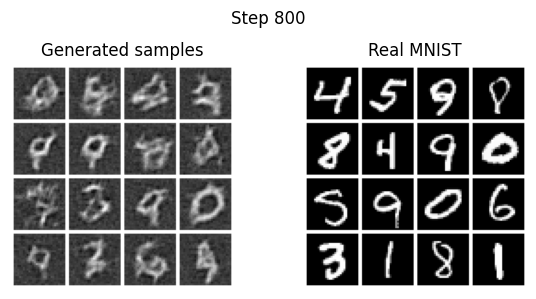

Training:   8%|██▉                                  | 800/10000 [06:54<1:25:12,  1.80it/s]

Step 800/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0480e+01, ratio_0.2=1.0132e+00, norm_0.2=2.6057e-02; lr=4.00e-04


Training:   8%|███                                  | 820/10000 [07:05<1:22:15,  1.86it/s]

Step 820/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0464e+01, ratio_0.2=1.0119e+00, norm_0.2=2.5354e-02; lr=4.00e-04


Training:   8%|███                                  | 840/10000 [07:16<1:22:50,  1.84it/s]

Step 840/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0445e+01, ratio_0.2=1.0105e+00, norm_0.2=2.4690e-02; lr=4.00e-04


Training:   9%|███▏                                 | 860/10000 [07:27<1:22:38,  1.84it/s]

Step 860/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0454e+01, ratio_0.2=1.0113e+00, norm_0.2=2.3963e-02; lr=4.00e-04


Training:   9%|███▎                                 | 880/10000 [07:37<1:14:24,  2.04it/s]

Step 880/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0456e+01, ratio_0.2=1.0115e+00, norm_0.2=2.3797e-02; lr=4.00e-04


Training:   9%|███▎                                 | 899/10000 [07:46<1:13:30,  2.06it/s]

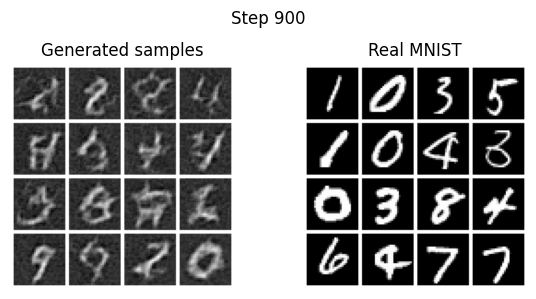

Training:   9%|███▎                                 | 900/10000 [07:47<1:15:25,  2.01it/s]

Step 900/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0455e+01, ratio_0.2=1.0110e+00, norm_0.2=2.4027e-02; lr=4.00e-04


Training:   9%|███▍                                 | 920/10000 [07:56<1:14:57,  2.02it/s]

Step 920/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0423e+01, ratio_0.2=1.0087e+00, norm_0.2=2.4108e-02; lr=4.00e-04


Training:   9%|███▍                                 | 940/10000 [08:07<1:20:22,  1.88it/s]

Step 940/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0414e+01, ratio_0.2=1.0076e+00, norm_0.2=2.4564e-02; lr=4.00e-04


Training:  10%|███▌                                 | 960/10000 [08:17<1:13:23,  2.05it/s]

Step 960/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0407e+01, ratio_0.2=1.0070e+00, norm_0.2=2.5613e-02; lr=4.00e-04


Training:  10%|███▋                                 | 980/10000 [08:27<1:12:37,  2.07it/s]

Step 980/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0426e+01, ratio_0.2=1.0084e+00, norm_0.2=2.5112e-02; lr=4.00e-04


Training:  10%|███▋                                 | 999/10000 [08:36<1:12:15,  2.08it/s]

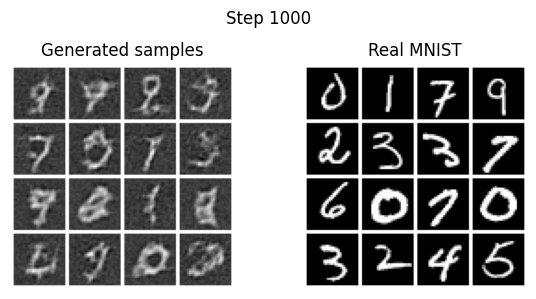

Training:  10%|███▌                                | 1000/10000 [08:36<1:14:06,  2.02it/s]

Step 1000/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0431e+01, ratio_0.2=1.0091e+00, norm_0.2=2.4632e-02; lr=4.00e-04


Training:  10%|███▋                                | 1020/10000 [08:46<1:12:02,  2.08it/s]

Step 1020/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0432e+01, ratio_0.2=1.0091e+00, norm_0.2=2.4178e-02; lr=4.00e-04


Training:  10%|███▋                                | 1040/10000 [08:56<1:12:07,  2.07it/s]

Step 1040/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0443e+01, ratio_0.2=1.0097e+00, norm_0.2=2.3763e-02; lr=4.00e-04


Training:  11%|███▊                                | 1060/10000 [09:05<1:12:05,  2.07it/s]

Step 1060/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0422e+01, ratio_0.2=1.0079e+00, norm_0.2=2.3449e-02; lr=4.00e-04


Training:  11%|███▉                                | 1080/10000 [09:15<1:11:57,  2.07it/s]

Step 1080/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0419e+01, ratio_0.2=1.0080e+00, norm_0.2=2.3136e-02; lr=4.00e-04


Training:  11%|███▉                                | 1099/10000 [09:24<1:13:24,  2.02it/s]

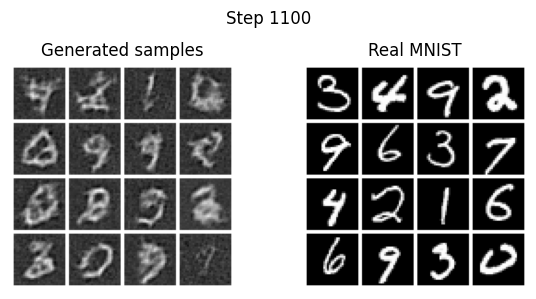

Training:  11%|███▉                                | 1100/10000 [09:25<1:17:04,  1.92it/s]

Step 1100/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0429e+01, ratio_0.2=1.0095e+00, norm_0.2=2.2557e-02; lr=4.00e-04


Training:  11%|████                                | 1120/10000 [09:35<1:16:46,  1.93it/s]

Step 1120/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0435e+01, ratio_0.2=1.0099e+00, norm_0.2=2.2241e-02; lr=4.00e-04


Training:  11%|████                                | 1140/10000 [09:46<1:18:20,  1.88it/s]

Step 1140/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0449e+01, ratio_0.2=1.0116e+00, norm_0.2=2.2013e-02; lr=4.00e-04


Training:  12%|████▏                               | 1160/10000 [09:56<1:15:34,  1.95it/s]

Step 1160/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0462e+01, ratio_0.2=1.0126e+00, norm_0.2=2.1616e-02; lr=4.00e-04


Training:  12%|████▏                               | 1180/10000 [10:06<1:11:31,  2.06it/s]

Step 1180/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0445e+01, ratio_0.2=1.0111e+00, norm_0.2=2.1716e-02; lr=4.00e-04


Training:  12%|████▎                               | 1199/10000 [10:16<1:16:48,  1.91it/s]

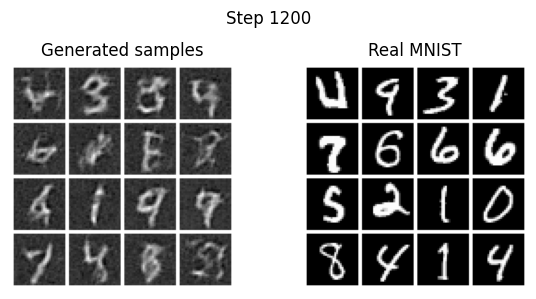

Training:  12%|████▎                               | 1200/10000 [10:16<1:18:53,  1.86it/s]

Step 1200/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0408e+01, ratio_0.2=1.0077e+00, norm_0.2=2.2114e-02; lr=4.00e-04


Training:  12%|████▍                               | 1220/10000 [10:27<1:15:07,  1.95it/s]

Step 1220/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0385e+01, ratio_0.2=1.0055e+00, norm_0.2=2.2473e-02; lr=4.00e-04


Training:  12%|████▍                               | 1240/10000 [10:37<1:14:46,  1.95it/s]

Step 1240/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0375e+01, ratio_0.2=1.0046e+00, norm_0.2=2.2759e-02; lr=4.00e-04


Training:  13%|████▌                               | 1260/10000 [10:47<1:15:10,  1.94it/s]

Step 1260/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0383e+01, ratio_0.2=1.0052e+00, norm_0.2=2.2863e-02; lr=4.00e-04


Training:  13%|████▌                               | 1280/10000 [10:57<1:11:37,  2.03it/s]

Step 1280/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0380e+01, ratio_0.2=1.0048e+00, norm_0.2=2.3011e-02; lr=4.00e-04


Training:  13%|████▋                               | 1299/10000 [11:07<1:11:56,  2.02it/s]

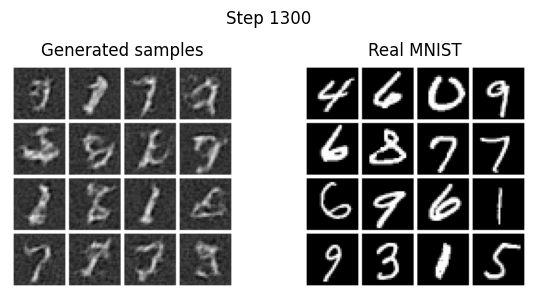

Training:  13%|████▋                               | 1300/10000 [11:07<1:14:12,  1.95it/s]

Step 1300/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0391e+01, ratio_0.2=1.0057e+00, norm_0.2=2.2524e-02; lr=4.00e-04


Training:  13%|████▊                               | 1320/10000 [11:17<1:10:04,  2.06it/s]

Step 1320/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0393e+01, ratio_0.2=1.0060e+00, norm_0.2=2.2241e-02; lr=4.00e-04


Training:  13%|████▊                               | 1340/10000 [11:27<1:11:02,  2.03it/s]

Step 1340/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0397e+01, ratio_0.2=1.0060e+00, norm_0.2=2.2530e-02; lr=4.00e-04


Training:  14%|████▉                               | 1360/10000 [11:37<1:10:27,  2.04it/s]

Step 1360/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0402e+01, ratio_0.2=1.0063e+00, norm_0.2=2.2289e-02; lr=4.00e-04


Training:  14%|████▉                               | 1380/10000 [11:46<1:10:19,  2.04it/s]

Step 1380/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0387e+01, ratio_0.2=1.0048e+00, norm_0.2=2.2694e-02; lr=4.00e-04


Training:  14%|█████                               | 1399/10000 [11:56<1:11:48,  2.00it/s]

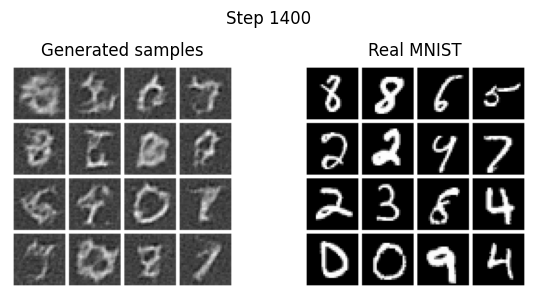

Training:  14%|█████                               | 1400/10000 [11:56<1:13:14,  1.96it/s]

Step 1400/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0390e+01, ratio_0.2=1.0051e+00, norm_0.2=2.2206e-02; lr=4.00e-04


Training:  14%|█████                               | 1420/10000 [12:06<1:08:43,  2.08it/s]

Step 1420/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0396e+01, ratio_0.2=1.0057e+00, norm_0.2=2.1809e-02; lr=4.00e-04


Training:  14%|█████▏                              | 1440/10000 [12:17<1:18:01,  1.83it/s]

Step 1440/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0403e+01, ratio_0.2=1.0065e+00, norm_0.2=2.1318e-02; lr=4.00e-04


Training:  15%|█████▎                              | 1460/10000 [12:28<1:13:30,  1.94it/s]

Step 1460/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0401e+01, ratio_0.2=1.0062e+00, norm_0.2=2.1524e-02; lr=4.00e-04


Training:  15%|█████▎                              | 1480/10000 [12:38<1:09:41,  2.04it/s]

Step 1480/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0391e+01, ratio_0.2=1.0055e+00, norm_0.2=2.1979e-02; lr=4.00e-04


Training:  15%|█████▍                              | 1499/10000 [12:47<1:12:18,  1.96it/s]

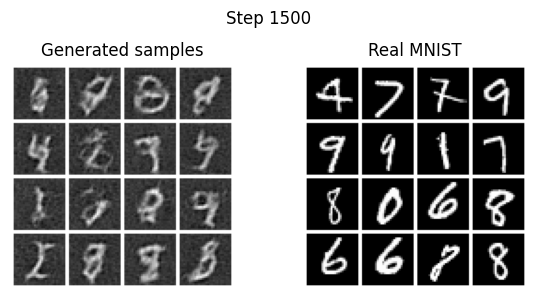

Training:  15%|█████▍                              | 1500/10000 [12:48<1:14:06,  1.91it/s]

Step 1500/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0380e+01, ratio_0.2=1.0044e+00, norm_0.2=2.2668e-02; lr=4.00e-04


Training:  15%|█████▍                              | 1520/10000 [12:58<1:09:33,  2.03it/s]

Step 1520/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0377e+01, ratio_0.2=1.0045e+00, norm_0.2=2.2432e-02; lr=4.00e-04


Training:  15%|█████▌                              | 1540/10000 [13:08<1:11:13,  1.98it/s]

Step 1540/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0362e+01, ratio_0.2=1.0035e+00, norm_0.2=2.2466e-02; lr=4.00e-04


Training:  16%|█████▌                              | 1560/10000 [13:17<1:09:31,  2.02it/s]

Step 1560/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0367e+01, ratio_0.2=1.0042e+00, norm_0.2=2.2888e-02; lr=4.00e-04


Training:  16%|█████▋                              | 1580/10000 [13:27<1:08:23,  2.05it/s]

Step 1580/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0358e+01, ratio_0.2=1.0035e+00, norm_0.2=2.2529e-02; lr=4.00e-04


Training:  16%|█████▊                              | 1599/10000 [13:37<1:08:29,  2.04it/s]

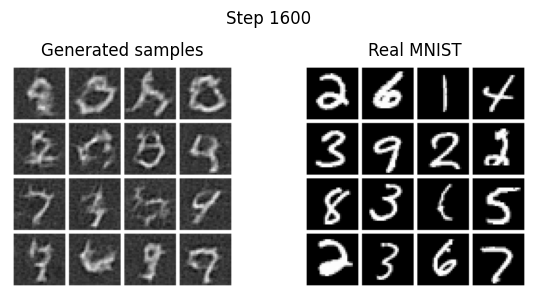

Training:  16%|█████▊                              | 1600/10000 [13:37<1:10:09,  2.00it/s]

Step 1600/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0369e+01, ratio_0.2=1.0042e+00, norm_0.2=2.2316e-02; lr=4.00e-04


Training:  16%|█████▊                              | 1620/10000 [13:47<1:09:50,  2.00it/s]

Step 1620/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0337e+01, ratio_0.2=1.0009e+00, norm_0.2=2.2755e-02; lr=4.00e-04


Training:  16%|█████▉                              | 1640/10000 [13:57<1:07:43,  2.06it/s]

Step 1640/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0293e+01, ratio_0.2=9.9684e-01, norm_0.2=2.3293e-02; lr=4.00e-04


Training:  17%|█████▉                              | 1660/10000 [14:07<1:07:31,  2.06it/s]

Step 1660/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0277e+01, ratio_0.2=9.9566e-01, norm_0.2=2.3348e-02; lr=4.00e-04


Training:  17%|██████                              | 1680/10000 [14:16<1:07:26,  2.06it/s]

Step 1680/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0287e+01, ratio_0.2=9.9621e-01, norm_0.2=2.3629e-02; lr=4.00e-04


Training:  17%|██████                              | 1699/10000 [14:26<1:07:08,  2.06it/s]

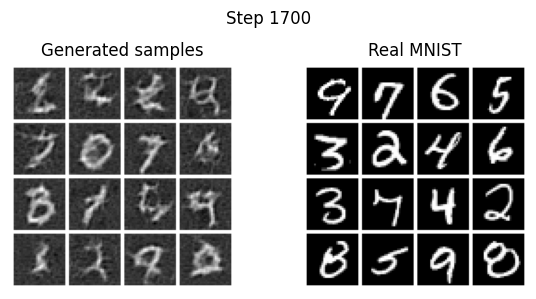

Training:  17%|██████                              | 1700/10000 [14:26<1:11:25,  1.94it/s]

Step 1700/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0294e+01, ratio_0.2=9.9683e-01, norm_0.2=2.3412e-02; lr=4.00e-04


Training:  17%|██████▏                             | 1720/10000 [14:36<1:06:50,  2.06it/s]

Step 1720/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0288e+01, ratio_0.2=9.9650e-01, norm_0.2=2.3325e-02; lr=4.00e-04


Training:  17%|██████▎                             | 1740/10000 [14:46<1:06:44,  2.06it/s]

Step 1740/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0301e+01, ratio_0.2=9.9775e-01, norm_0.2=2.2542e-02; lr=4.00e-04


Training:  18%|██████▎                             | 1760/10000 [14:55<1:06:39,  2.06it/s]

Step 1760/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0272e+01, ratio_0.2=9.9505e-01, norm_0.2=2.2988e-02; lr=4.00e-04


Training:  18%|██████▍                             | 1780/10000 [15:05<1:07:04,  2.04it/s]

Step 1780/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0249e+01, ratio_0.2=9.9323e-01, norm_0.2=2.4054e-02; lr=4.00e-04


Training:  18%|██████▍                             | 1799/10000 [15:14<1:06:37,  2.05it/s]

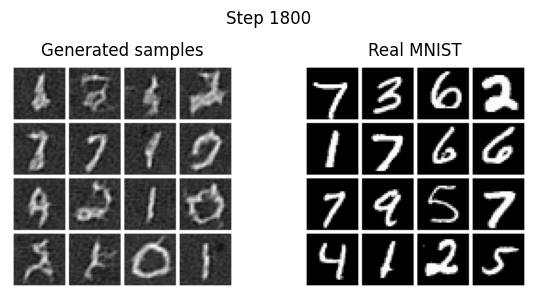

Training:  18%|██████▍                             | 1800/10000 [15:15<1:08:16,  2.00it/s]

Step 1800/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0237e+01, ratio_0.2=9.9209e-01, norm_0.2=2.4148e-02; lr=4.00e-04


Training:  18%|██████▌                             | 1820/10000 [15:25<1:06:54,  2.04it/s]

Step 1820/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0218e+01, ratio_0.2=9.9061e-01, norm_0.2=2.3524e-02; lr=4.00e-04


Training:  18%|██████▌                             | 1840/10000 [15:35<1:07:11,  2.02it/s]

Step 1840/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0220e+01, ratio_0.2=9.9119e-01, norm_0.2=2.2724e-02; lr=4.00e-04


Training:  19%|██████▋                             | 1860/10000 [15:44<1:06:15,  2.05it/s]

Step 1860/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0239e+01, ratio_0.2=9.9302e-01, norm_0.2=2.2154e-02; lr=4.00e-04


Training:  19%|██████▊                             | 1880/10000 [15:54<1:07:21,  2.01it/s]

Step 1880/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0296e+01, ratio_0.2=9.9778e-01, norm_0.2=2.1822e-02; lr=4.00e-04


Training:  19%|██████▊                             | 1899/10000 [16:04<1:06:52,  2.02it/s]

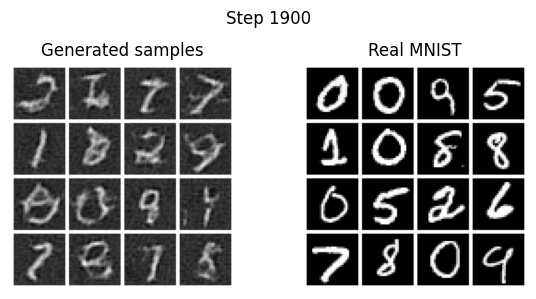

Training:  19%|██████▊                             | 1900/10000 [16:04<1:07:59,  1.99it/s]

Step 1900/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0291e+01, ratio_0.2=9.9744e-01, norm_0.2=2.1675e-02; lr=4.00e-04


Training:  19%|██████▉                             | 1920/10000 [16:14<1:09:19,  1.94it/s]

Step 1920/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0322e+01, ratio_0.2=1.0005e+00, norm_0.2=2.1119e-02; lr=4.00e-04


Training:  19%|██████▉                             | 1940/10000 [16:24<1:08:34,  1.96it/s]

Step 1940/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0302e+01, ratio_0.2=9.9860e-01, norm_0.2=2.1462e-02; lr=4.00e-04


Training:  20%|███████                             | 1960/10000 [16:34<1:06:07,  2.03it/s]

Step 1960/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0318e+01, ratio_0.2=1.0003e+00, norm_0.2=2.1489e-02; lr=4.00e-04


Training:  20%|███████▏                            | 1980/10000 [16:44<1:05:59,  2.03it/s]

Step 1980/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0302e+01, ratio_0.2=9.9922e-01, norm_0.2=2.1739e-02; lr=4.00e-04


Training:  20%|███████▏                            | 1999/10000 [16:54<1:06:50,  1.99it/s]

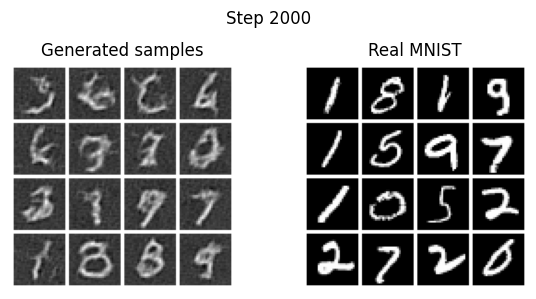

Training:  20%|███████▏                            | 2000/10000 [16:55<1:08:16,  1.95it/s]

Step 2000/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0305e+01, ratio_0.2=9.9916e-01, norm_0.2=2.1028e-02; lr=4.00e-04


Training:  20%|███████▎                            | 2020/10000 [17:05<1:09:30,  1.91it/s]

Step 2020/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0301e+01, ratio_0.2=9.9849e-01, norm_0.2=2.0578e-02; lr=4.00e-04


Training:  20%|███████▎                            | 2040/10000 [17:16<1:15:13,  1.76it/s]

Step 2040/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0302e+01, ratio_0.2=9.9892e-01, norm_0.2=2.0329e-02; lr=4.00e-04


Training:  21%|███████▍                            | 2060/10000 [17:26<1:08:49,  1.92it/s]

Step 2060/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0323e+01, ratio_0.2=1.0007e+00, norm_0.2=2.0434e-02; lr=4.00e-04


Training:  21%|███████▍                            | 2080/10000 [17:36<1:06:09,  2.00it/s]

Step 2080/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0317e+01, ratio_0.2=9.9976e-01, norm_0.2=2.0643e-02; lr=4.00e-04


Training:  21%|███████▌                            | 2099/10000 [17:46<1:11:29,  1.84it/s]

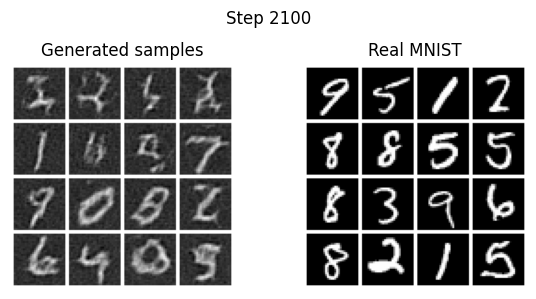

Training:  21%|███████▌                            | 2100/10000 [17:47<1:14:16,  1.77it/s]

Step 2100/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0312e+01, ratio_0.2=9.9925e-01, norm_0.2=2.0926e-02; lr=4.00e-04


Training:  21%|███████▋                            | 2120/10000 [17:57<1:08:02,  1.93it/s]

Step 2120/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0318e+01, ratio_0.2=9.9962e-01, norm_0.2=2.0582e-02; lr=4.00e-04


Training:  21%|███████▋                            | 2140/10000 [18:09<1:13:02,  1.79it/s]

Step 2140/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0312e+01, ratio_0.2=9.9887e-01, norm_0.2=2.0751e-02; lr=4.00e-04


Training:  22%|███████▊                            | 2160/10000 [18:20<1:15:42,  1.73it/s]

Step 2160/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0288e+01, ratio_0.2=9.9666e-01, norm_0.2=2.1660e-02; lr=4.00e-04


Training:  22%|███████▊                            | 2180/10000 [18:31<1:11:04,  1.83it/s]

Step 2180/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0301e+01, ratio_0.2=9.9805e-01, norm_0.2=2.1805e-02; lr=4.00e-04


Training:  22%|███████▉                            | 2199/10000 [18:41<1:09:31,  1.87it/s]

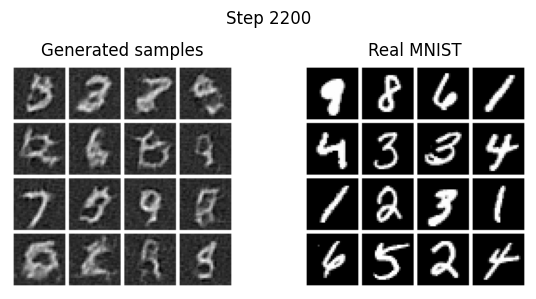

Training:  22%|███████▉                            | 2200/10000 [18:42<1:11:09,  1.83it/s]

Step 2200/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0303e+01, ratio_0.2=9.9872e-01, norm_0.2=2.1501e-02; lr=4.00e-04


Training:  22%|███████▉                            | 2220/10000 [18:53<1:10:00,  1.85it/s]

Step 2220/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0315e+01, ratio_0.2=9.9983e-01, norm_0.2=2.1262e-02; lr=4.00e-04


Training:  22%|████████                            | 2240/10000 [19:04<1:10:41,  1.83it/s]

Step 2240/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0323e+01, ratio_0.2=1.0002e+00, norm_0.2=2.1541e-02; lr=4.00e-04


Training:  23%|████████▏                           | 2260/10000 [19:14<1:10:29,  1.83it/s]

Step 2260/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0315e+01, ratio_0.2=9.9936e-01, norm_0.2=2.1254e-02; lr=4.00e-04


Training:  23%|████████▏                           | 2280/10000 [19:25<1:11:31,  1.80it/s]

Step 2280/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0325e+01, ratio_0.2=1.0002e+00, norm_0.2=2.1646e-02; lr=4.00e-04


Training:  23%|████████▎                           | 2299/10000 [19:36<1:11:01,  1.81it/s]

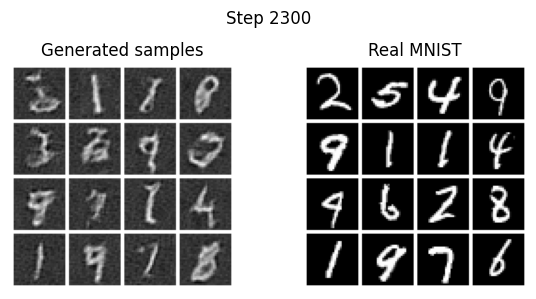

Training:  23%|████████▎                           | 2300/10000 [19:37<1:12:52,  1.76it/s]

Step 2300/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0319e+01, ratio_0.2=1.0000e+00, norm_0.2=2.1356e-02; lr=4.00e-04


Training:  23%|████████▎                           | 2320/10000 [19:48<1:09:10,  1.85it/s]

Step 2320/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0308e+01, ratio_0.2=9.9893e-01, norm_0.2=2.1308e-02; lr=4.00e-04


Training:  23%|████████▍                           | 2340/10000 [19:59<1:11:13,  1.79it/s]

Step 2340/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0320e+01, ratio_0.2=1.0005e+00, norm_0.2=2.0928e-02; lr=4.00e-04


Training:  24%|████████▍                           | 2360/10000 [20:10<1:10:33,  1.80it/s]

Step 2360/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0311e+01, ratio_0.2=9.9934e-01, norm_0.2=2.1027e-02; lr=4.00e-04


Training:  24%|████████▌                           | 2380/10000 [20:21<1:10:42,  1.80it/s]

Step 2380/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0308e+01, ratio_0.2=9.9903e-01, norm_0.2=2.1060e-02; lr=4.00e-04


Training:  24%|████████▋                           | 2399/10000 [20:32<1:10:37,  1.79it/s]

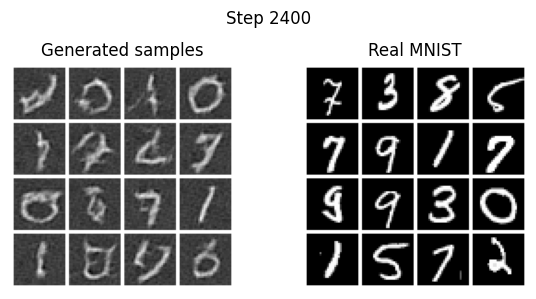

Training:  24%|████████▋                           | 2400/10000 [20:32<1:11:48,  1.76it/s]

Step 2400/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0265e+01, ratio_0.2=9.9519e-01, norm_0.2=2.1121e-02; lr=4.00e-04


Training:  24%|████████▋                           | 2420/10000 [20:43<1:10:40,  1.79it/s]

Step 2420/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0261e+01, ratio_0.2=9.9423e-01, norm_0.2=2.1001e-02; lr=4.00e-04


Training:  24%|████████▊                           | 2440/10000 [20:54<1:10:48,  1.78it/s]

Step 2440/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0263e+01, ratio_0.2=9.9416e-01, norm_0.2=2.0961e-02; lr=4.00e-04


Training:  25%|████████▊                           | 2460/10000 [21:05<1:02:09,  2.02it/s]

Step 2460/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0290e+01, ratio_0.2=9.9625e-01, norm_0.2=2.1106e-02; lr=4.00e-04


Training:  25%|████████▉                           | 2480/10000 [21:15<1:02:45,  2.00it/s]

Step 2480/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0279e+01, ratio_0.2=9.9571e-01, norm_0.2=2.1315e-02; lr=4.00e-04


Training:  25%|████████▉                           | 2499/10000 [21:24<1:06:06,  1.89it/s]

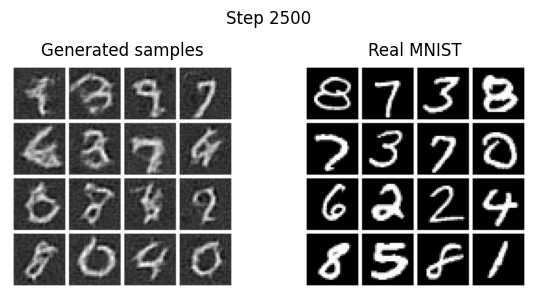

Training:  25%|█████████                           | 2500/10000 [21:25<1:06:54,  1.87it/s]

Step 2500/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0294e+01, ratio_0.2=9.9762e-01, norm_0.2=2.0723e-02; lr=4.00e-04


Training:  25%|█████████                           | 2520/10000 [21:35<1:08:15,  1.83it/s]

Step 2520/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0304e+01, ratio_0.2=9.9843e-01, norm_0.2=2.0720e-02; lr=4.00e-04


Training:  25%|█████████▏                          | 2540/10000 [21:46<1:08:26,  1.82it/s]

Step 2540/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0292e+01, ratio_0.2=9.9730e-01, norm_0.2=2.0703e-02; lr=4.00e-04


Training:  26%|█████████▏                          | 2560/10000 [21:57<1:04:14,  1.93it/s]

Step 2560/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0299e+01, ratio_0.2=9.9719e-01, norm_0.2=2.0455e-02; lr=4.00e-04


Training:  26%|█████████▊                            | 2580/10000 [22:07<59:58,  2.06it/s]

Step 2580/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0316e+01, ratio_0.2=9.9877e-01, norm_0.2=2.0077e-02; lr=4.00e-04


Training:  26%|█████████▎                          | 2599/10000 [22:17<1:03:18,  1.95it/s]

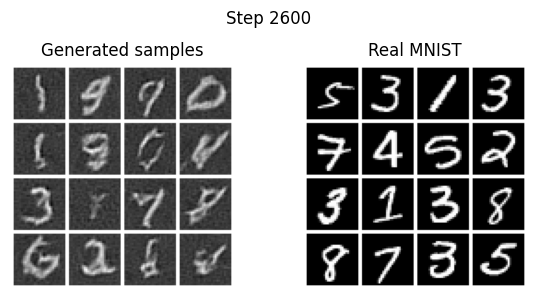

Training:  26%|█████████▎                          | 2600/10000 [22:18<1:04:38,  1.91it/s]

Step 2600/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0324e+01, ratio_0.2=9.9999e-01, norm_0.2=1.9761e-02; lr=4.00e-04


Training:  26%|█████████▍                          | 2620/10000 [22:28<1:05:56,  1.87it/s]

Step 2620/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0326e+01, ratio_0.2=1.0003e+00, norm_0.2=1.9939e-02; lr=4.00e-04


Training:  26%|█████████▌                          | 2640/10000 [22:39<1:07:23,  1.82it/s]

Step 2640/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0337e+01, ratio_0.2=1.0013e+00, norm_0.2=2.0055e-02; lr=4.00e-04


Training:  27%|█████████▌                          | 2660/10000 [22:50<1:05:20,  1.87it/s]

Step 2660/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0303e+01, ratio_0.2=9.9778e-01, norm_0.2=2.1281e-02; lr=4.00e-04


Training:  27%|█████████▋                          | 2680/10000 [23:01<1:07:14,  1.81it/s]

Step 2680/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0297e+01, ratio_0.2=9.9786e-01, norm_0.2=2.0990e-02; lr=4.00e-04


Training:  27%|█████████▋                          | 2699/10000 [23:11<1:08:14,  1.78it/s]

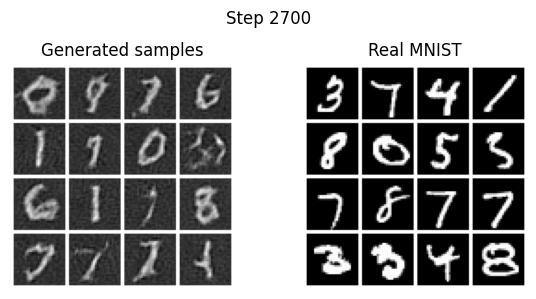

Training:  27%|█████████▋                          | 2700/10000 [23:12<1:09:41,  1.75it/s]

Step 2700/10000: EMA Loss=1.0000e+00; EMA infos: mean_dist=2.0315e+01, ratio_0.2=9.9945e-01, norm_0.2=2.0686e-02; lr=4.00e-04


Training:  27%|█████████▊                          | 2718/10000 [23:22<1:02:38,  1.94it/s]


KeyboardInterrupt: 

In [7]:

model, losses, drift_mags = train_mnist(
    steps=10000,
    n_feats=64,
    temp=[0.2],
    lr=4e-4,
    batch_size=2048,
    gen_batch_size=1024,
    warmup_steps=500,
    plot_interval=100,
    use_mlp=False, 
    log_every=20,
    grad_clip_norm=1.0     # explicitly set clip norm, or adjust as desired
)

# MNIST with feature loss!

Below, we show an example of using feature losses to improve the training of MNIST models. This idea is crucial for high dimensional data in general. 

First, let's modify the drifting loss to support a batch of features. 

In [15]:
# ============================================================
# Core: Compute Drift V and Loss (from toy_mean_drift.py)
# ============================================================

def cdist(x, y, eps=1e-8):
    """
    Args:
        x: [B, C1, D]
        y: [B, C2, D]
    Returns: [B, C1, C2]

    Same effect as torch.cdist, but faster.
    """
    xydot = torch.einsum("bnd,bmd->bnm", x, y)
    xnorms = torch.einsum("bnd,bnd->bn", x, x)
    ynorms = torch.einsum("bmd,bmd->bm", y, y)
    return (xnorms[:, :, None] + ynorms[:, None, :] - 2 * xydot).clamp(min=eps).sqrt()


def compute_drift(gen: torch.Tensor, pos: torch.Tensor, temps = [0.1, 0.2]):
    """
    Compute drift field V with attention-based kernel.
    
    Args:
        gen: Generated samples [B, G, D]
        pos: Data samples [B, P, D]
        temp: Temperature for softmax kernel
        Each batch is computed independently. 
    
    Returns:
        V: Drift vectors [B, G, D]
    """
    targets = torch.cat([gen, pos], dim=-2)
    # print(targets.shape, gen.shape)
    G = gen.shape[-2]

    dist = cdist(gen, targets) # [B, G, P]

    info = dict()
    mean_dist = dist.mean()        
    # mean_dist = mean_scale
    info['mean_dist'] = mean_dist
    dist[:, :, :G] += torch.eye(G,device=dist.device) * 1e6
    total_V = torch.zeros_like(gen)
    for temp in temps:
        scale = temp * mean_dist # Change here: temp should be of the same order as average distance

        kernel = (-dist / scale).softmax(dim=-1)
        kernel = (kernel * (-dist / scale).softmax(dim=-2)).clamp_min(0).sqrt()

        w_pos = kernel[:, :, G:] * kernel[:, :, :G].sum(dim=-1, keepdim=True)
        w_neg = kernel[:, :, :G] * kernel[:, :, G:].sum(dim=-1, keepdim=True)
        info[f'ratio_{temp}'] = kernel[:, :, G:].mean() / kernel[:, :G].mean()
        drift_coeff = torch.cat([-w_neg, w_pos], dim=-1)

        temp_V = drift_coeff @ targets
        # print(temp_V.shape)
        info[f'norm_{temp}'] = (temp_V ** 2).mean().clamp_min(1e-8).sqrt()
        temp_V = temp_V / info[f'norm_{temp}']
        total_V = total_V + temp_V

    return total_V, info


def drifting_loss(gen: torch.Tensor, pos: torch.Tensor, temp = [0.05, 0.1, 0.2]):
    """Drifting loss: MSE(gen, stopgrad(gen + V))."""
    with torch.no_grad():
        V, info = compute_drift(gen, pos, temp)
        target = (gen + V).detach()
    return F.mse_loss(gen, target), V.pow(2).mean().item(), info

# drifting_loss(torch.randn(3, 16, 256), torch.randn(3, 16, 256))


Next, we show how to compute features for a batch of samples. 

In [20]:
from einops import rearrange
def patchify(x, kernel):
    '''
    Args:
        img: [B, C, H, W]
        kernel: int
    Returns:
        [B, H*W, C*p*p]: the features of all psz * psz patches!
        Reflects when lands outside
    '''

    B, C, H, W = x.shape
    assert kernel > 1, "kernel must be greater than 1"
    assert H > 1 and W > 1, "H and W must be greater than 1"
    device = x.device
    b_idx, kh_idx, kw_idx, h_idx, w_idx = torch.meshgrid(
        torch.arange(B, device=device),
        torch.arange(kernel, device=device),
        torch.arange(kernel, device=device),
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing='ij'
    )
    h_idx = (h_idx + kh_idx) % (2 * H - 2)
    h_idx = torch.minimum(h_idx, 2 * H - 2 - h_idx)
    w_idx = (w_idx + kw_idx) % (2 * W - 2)
    w_idx = torch.minimum(w_idx, 2 * W - 2 - w_idx)
    indices = b_idx * H * W + h_idx * W + w_idx
    x_flatten = rearrange(x, 'b c h w -> (b h w) c')
    result = x_flatten[indices.flatten()]
    unfolded_feats = result.reshape(B, kernel, kernel, H, W, C)
    return rearrange(unfolded_feats, 'b k l h w c -> b (h w) (k l c)')
# print(patchify(torch.randn(1, 1, 28, 28), 5).shape)


def feature_extractor(x, kernel_list = [], ds=2):
    '''
    Args:
        x: [B, C, H, W]
        ds: how much to downsample (to save compute)
    Returns:
        A dict of (k: [B, F, D])
    '''
    res = dict()
    B, C, H, W = x.shape
    res['global'] = x.reshape(B, 1, C * H * W)    
    x = rearrange(x, 'b c (h1 h2) (w1 w2) -> b c h1 w1 (h2 w2)', h2=2,w2=2).mean(dim=-1)

    for k in kernel_list:
        res[f'patch{k}'] = patchify(x, k)
    return res
    

Using device: mps


Training:   0%|                                                 | 0/20000 [00:00<?, ?it/s]

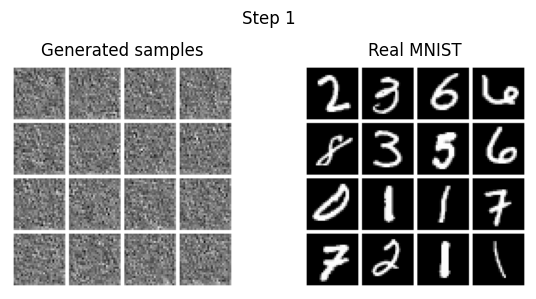

Training:   0%|                                      | 20/20000 [00:07<1:41:42,  3.27it/s]

Step 20/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=2.4231e-01, norm_patch3=9.9724e-02, norm_patch5=1.0273e-01; lr=1.60e-05


Training:   0%|                                      | 40/20000 [00:17<2:46:37,  2.00it/s]

Step 40/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=2.3976e-01, norm_patch3=1.0399e-01, norm_patch5=1.0482e-01; lr=3.20e-05


Training:   0%|                                      | 60/20000 [00:26<2:17:27,  2.42it/s]

Step 60/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=2.3051e-01, norm_patch3=1.1088e-01, norm_patch5=1.0883e-01; lr=4.80e-05


Training:   0%|▏                                     | 80/20000 [00:32<1:40:58,  3.29it/s]

Step 80/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=2.1351e-01, norm_patch3=1.0043e-01, norm_patch5=9.7618e-02; lr=6.40e-05


Training:   0%|▏                                     | 99/20000 [00:38<1:39:48,  3.32it/s]

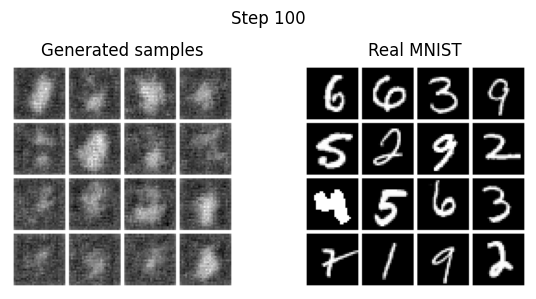

Training:   0%|▏                                    | 100/20000 [00:38<1:45:02,  3.16it/s]

Step 100/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=1.9136e-01, norm_patch3=9.1389e-02, norm_patch5=8.8789e-02; lr=8.00e-05


Training:   1%|▏                                    | 120/20000 [00:44<1:39:35,  3.33it/s]

Step 120/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=1.6733e-01, norm_patch3=8.6447e-02, norm_patch5=8.3592e-02; lr=9.60e-05


Training:   1%|▎                                    | 140/20000 [00:50<1:40:05,  3.31it/s]

Step 140/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=1.4482e-01, norm_patch3=8.1000e-02, norm_patch5=7.8088e-02; lr=1.12e-04


Training:   1%|▎                                    | 160/20000 [00:56<1:39:36,  3.32it/s]

Step 160/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=1.2507e-01, norm_patch3=7.5104e-02, norm_patch5=7.2713e-02; lr=1.28e-04


Training:   1%|▎                                    | 180/20000 [01:02<1:39:36,  3.32it/s]

Step 180/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=1.0839e-01, norm_patch3=6.9703e-02, norm_patch5=6.7861e-02; lr=1.44e-04


Training:   1%|▎                                    | 199/20000 [01:08<1:39:11,  3.33it/s]

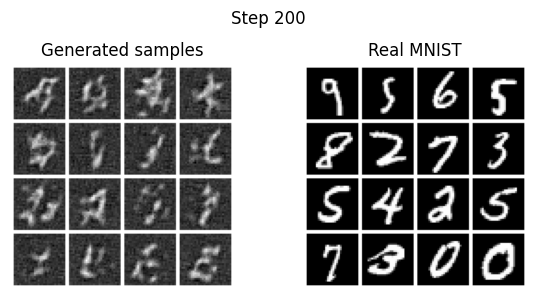

Training:   1%|▎                                    | 200/20000 [01:09<1:43:21,  3.19it/s]

Step 200/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=9.4671e-02, norm_patch3=6.4980e-02, norm_patch5=6.3640e-02; lr=1.60e-04


Training:   1%|▍                                    | 220/20000 [01:15<1:39:25,  3.32it/s]

Step 220/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=8.2825e-02, norm_patch3=6.0881e-02, norm_patch5=5.9816e-02; lr=1.76e-04


Training:   1%|▍                                    | 240/20000 [01:21<1:39:51,  3.30it/s]

Step 240/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=7.3082e-02, norm_patch3=5.7291e-02, norm_patch5=5.6508e-02; lr=1.92e-04


Training:   1%|▍                                    | 260/20000 [01:27<1:39:25,  3.31it/s]

Step 260/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=6.5258e-02, norm_patch3=5.4047e-02, norm_patch5=5.3542e-02; lr=2.08e-04


Training:   1%|▌                                    | 280/20000 [01:33<1:39:58,  3.29it/s]

Step 280/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=5.8989e-02, norm_patch3=5.1123e-02, norm_patch5=5.0926e-02; lr=2.24e-04


Training:   1%|▌                                    | 299/20000 [01:39<1:40:37,  3.26it/s]

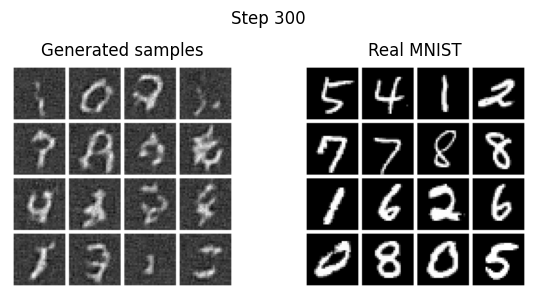

Training:   2%|▌                                    | 300/20000 [01:39<1:44:36,  3.14it/s]

Step 300/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=5.3634e-02, norm_patch3=4.8509e-02, norm_patch5=4.8567e-02; lr=2.40e-04


Training:   2%|▌                                    | 320/20000 [01:45<1:39:58,  3.28it/s]

Step 320/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=4.9276e-02, norm_patch3=4.6233e-02, norm_patch5=4.6583e-02; lr=2.56e-04


Training:   2%|▋                                    | 340/20000 [01:51<1:39:59,  3.28it/s]

Step 340/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=4.5427e-02, norm_patch3=4.4197e-02, norm_patch5=4.4734e-02; lr=2.72e-04


Training:   2%|▋                                    | 360/20000 [01:57<1:40:48,  3.25it/s]

Step 360/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=4.2828e-02, norm_patch3=4.2505e-02, norm_patch5=4.3341e-02; lr=2.88e-04


Training:   2%|▋                                    | 380/20000 [02:03<1:40:04,  3.27it/s]

Step 380/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=4.0752e-02, norm_patch3=4.1189e-02, norm_patch5=4.2245e-02; lr=3.04e-04


Training:   2%|▋                                    | 399/20000 [02:09<1:40:02,  3.27it/s]

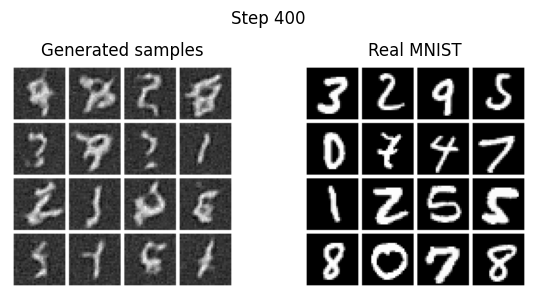

Training:   2%|▋                                    | 400/20000 [02:10<1:44:07,  3.14it/s]

Step 400/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.9650e-02, norm_patch3=4.0083e-02, norm_patch5=4.1518e-02; lr=3.20e-04


Training:   2%|▊                                    | 420/20000 [02:16<1:40:16,  3.25it/s]

Step 420/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.8696e-02, norm_patch3=3.9152e-02, norm_patch5=4.0885e-02; lr=3.36e-04


Training:   2%|▊                                    | 440/20000 [02:22<1:40:30,  3.24it/s]

Step 440/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.7629e-02, norm_patch3=3.8372e-02, norm_patch5=4.0259e-02; lr=3.52e-04


Training:   2%|▊                                    | 460/20000 [02:28<1:40:57,  3.23it/s]

Step 460/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.6210e-02, norm_patch3=3.7602e-02, norm_patch5=3.9499e-02; lr=3.68e-04


Training:   2%|▉                                    | 480/20000 [02:34<1:42:41,  3.17it/s]

Step 480/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.5189e-02, norm_patch3=3.6981e-02, norm_patch5=3.9003e-02; lr=3.84e-04


Training:   2%|▉                                    | 499/20000 [02:40<1:45:14,  3.09it/s]

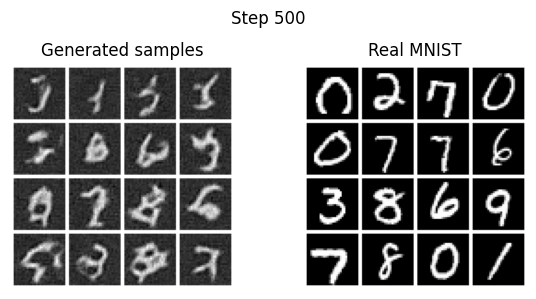

Training:   2%|▉                                    | 500/20000 [02:41<1:49:47,  2.96it/s]

Step 500/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.4493e-02, norm_patch3=3.6410e-02, norm_patch5=3.8547e-02; lr=4.00e-04


Training:   3%|▉                                    | 520/20000 [02:48<1:48:17,  3.00it/s]

Step 520/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.3821e-02, norm_patch3=3.5991e-02, norm_patch5=3.8095e-02; lr=4.00e-04


Training:   3%|▉                                    | 540/20000 [02:54<1:51:13,  2.92it/s]

Step 540/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.3183e-02, norm_patch3=3.5428e-02, norm_patch5=3.7599e-02; lr=4.00e-04


Training:   3%|█                                    | 560/20000 [03:01<1:56:15,  2.79it/s]

Step 560/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.3127e-02, norm_patch3=3.5088e-02, norm_patch5=3.7375e-02; lr=4.00e-04


Training:   3%|█                                    | 580/20000 [03:09<1:57:26,  2.76it/s]

Step 580/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.3200e-02, norm_patch3=3.4816e-02, norm_patch5=3.7226e-02; lr=4.00e-04


Training:   3%|█                                    | 599/20000 [03:16<2:01:18,  2.67it/s]

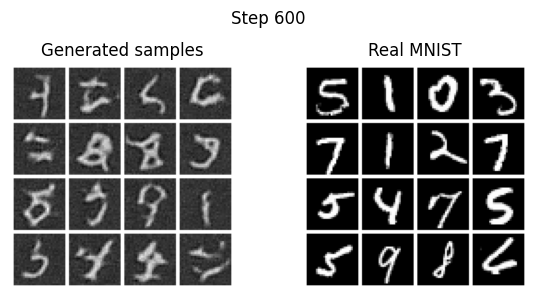

Training:   3%|█                                    | 600/20000 [03:16<2:05:42,  2.57it/s]

Step 600/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.2559e-02, norm_patch3=3.4482e-02, norm_patch5=3.6790e-02; lr=4.00e-04


Training:   3%|█▏                                   | 620/20000 [03:24<2:01:06,  2.67it/s]

Step 620/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.1693e-02, norm_patch3=3.4037e-02, norm_patch5=3.6195e-02; lr=4.00e-04


Training:   3%|█▏                                   | 640/20000 [03:31<2:03:15,  2.62it/s]

Step 640/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.1603e-02, norm_patch3=3.3736e-02, norm_patch5=3.5973e-02; lr=4.00e-04


Training:   3%|█▏                                   | 660/20000 [03:39<2:01:17,  2.66it/s]

Step 660/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.1193e-02, norm_patch3=3.3504e-02, norm_patch5=3.5685e-02; lr=4.00e-04


Training:   3%|█▎                                   | 680/20000 [03:47<2:05:37,  2.56it/s]

Step 680/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.0801e-02, norm_patch3=3.3195e-02, norm_patch5=3.5276e-02; lr=4.00e-04


Training:   3%|█▎                                   | 699/20000 [03:54<2:11:45,  2.44it/s]

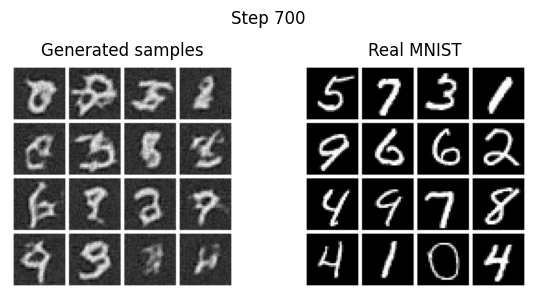

Training:   4%|█▎                                   | 700/20000 [03:55<2:13:25,  2.41it/s]

Step 700/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.0817e-02, norm_patch3=3.3017e-02, norm_patch5=3.5175e-02; lr=4.00e-04


Training:   4%|█▎                                   | 720/20000 [04:02<2:00:36,  2.66it/s]

Step 720/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.0505e-02, norm_patch3=3.2822e-02, norm_patch5=3.5002e-02; lr=4.00e-04


Training:   4%|█▎                                   | 740/20000 [04:10<1:57:55,  2.72it/s]

Step 740/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.0684e-02, norm_patch3=3.2750e-02, norm_patch5=3.5021e-02; lr=4.00e-04


Training:   4%|█▍                                   | 760/20000 [04:17<1:55:37,  2.77it/s]

Step 760/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.0242e-02, norm_patch3=3.2577e-02, norm_patch5=3.4716e-02; lr=4.00e-04


Training:   4%|█▍                                   | 780/20000 [04:24<1:54:58,  2.79it/s]

Step 780/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=3.0022e-02, norm_patch3=3.2388e-02, norm_patch5=3.4582e-02; lr=4.00e-04


Training:   4%|█▍                                   | 799/20000 [04:31<1:55:45,  2.76it/s]

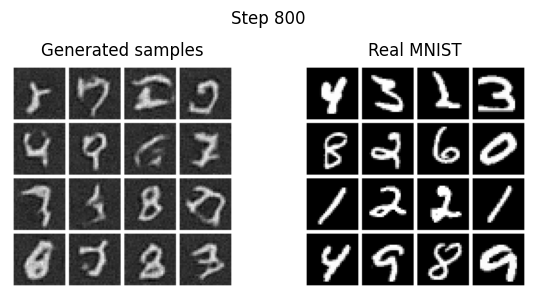

Training:   4%|█▍                                   | 800/20000 [04:32<1:59:12,  2.68it/s]

Step 800/20000: EMA Loss=3.0000e+00; EMA infos: norm_global=2.9726e-02, norm_patch3=3.2236e-02, norm_patch5=3.4427e-02; lr=4.00e-04


Training:   4%|█▍                                   | 806/20000 [04:34<1:48:58,  2.94it/s]


KeyboardInterrupt: 

In [21]:
import torchvision
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import trange

import torch.nn.utils as nn_utils  # Add this import for gradient clipping
def train_mnist(
    n_feats=32, 
    noise_dim=128,
    batch_size=512,
    gen_batch_size=512,
    kernel_list = [],
    steps=20000,                  # Use steps instead of epochs
    plot_interval=500,            # Plot every N steps
    lr=1e-3,
    temp=[0.05, 0.1, 0.2],
    device=None,
    warmup_steps=500,
    log_every=50,
    use_mlp=False,
    grad_clip_norm=1.0,           # <-- add a grad_clip_norm parameter (default 1.0)
):
    # Setup dataset & model
    device = device or ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    data_tensor = mnist_train.data.float() / 255.0
    data_tensor = data_tensor * 2 - 1   # [-1, 1] like normalization above
    data_tensor = data_tensor.unsqueeze(1)  # (N,1,28,28)
    # print(data_tensor.min(), data_tensor.max()) 
    # 
    if use_mlp:
        model = MLP(in_dim=784, hidden=256, out_dim=28*28, device=device)
    else:
        model = ContextUnet(in_channels=1, n_feat=n_feats, noise_dim=noise_dim, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def get_warmup_lr(step, base_lr, warmup_steps):
        if warmup_steps == 0:
            return base_lr
        return base_lr * min(1.0, (step + 1) / warmup_steps)
    
    losses = []
    drift_mags = []

    # Global running EMA for loss/info (not reset per epoch)
    ema_infos = dict()  # key: info key (e.g., norm), value: current ema
    alpha = 0.01        # EMA smoothing for loss and infos
    loss_ema = None     # Not reset per epoch

    # Main training loop, sample random batches from entire MNIST
    num_total = data_tensor.shape[0]

    for step in trange(steps, desc="Training", ncols=90):
        model.train()
        # Randomly sample indices for batch
        idx = np.random.choice(num_total, batch_size, replace=False)
        real_imgs = data_tensor[idx].to(device)   # (B, 1, 28, 28)

        gen_imgs = model.generate(gen_batch_size)

        real_features = feature_extractor(real_imgs, kernel_list)
        gen_features = feature_extractor(gen_imgs, kernel_list)

        total_loss = 0
        info = dict()
        for k in real_features.keys():
          feats_x, feats_y = real_features[k], gen_features[k] # [Data, F, D]; [G, F, D]
          feats_x = feats_x.permute(1, 0, 2)
          feats_y = feats_y.permute(1, 0, 2)
          loss, drift_mag, cur_info = drifting_loss(feats_y, feats_x, temp=temp)
          total_loss = total_loss + loss
          info[f'norm_{k}'] = cur_info[f'norm_{temp[0]}']
      
        optimizer.zero_grad()
        total_loss.backward()

        # ------- Clip gradient norm here -------
        nn_utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
        # ----------------------------------------

        # ---- Learning rate warmup update ----
        warmup_lr = get_warmup_lr(step, lr, warmup_steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] = warmup_lr

        optimizer.step()

        # Keep track of running (not "per epoch") loss and info
        loss_scalar = float(total_loss.item())
        if loss_ema is None:
            loss_ema = loss_scalar
        else:
            loss_ema = alpha * loss_scalar + (1 - alpha) * loss_ema

        for k, v in info.items():
            v_scalar = float(v.item()) if hasattr(v, 'item') else float(v)
            if k not in ema_infos:
                ema_infos[k] = v_scalar
            else:
                ema_infos[k] = alpha * v_scalar + (1 - alpha) * ema_infos[k]

        # Store every N steps for plotting/inspection
        if (step+1) % plot_interval == 0 or step == 0:
            losses.append(loss_ema)
            drift_mags.append(ema_infos.get("norm_{}".format(temp[0]), 0.0))
            # Print/visualize generated samples for debugging
            model.eval()
            with torch.no_grad():
                fig, axes = plt.subplots(1, 2, figsize=(6, 3))
                # Plot a grid of generated images
                gen_samples = model.generate(16).cpu()
                grid = torchvision.utils.make_grid(gen_samples, nrow=4, normalize=True, pad_value=1)
                axes[0].imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
                axes[0].axis('off')
                axes[0].set_title("Generated samples")
                # Plot a grid of real images for comparison
                real_samples_from_data = data_tensor[idx][:16].cpu()
                real_grid = torchvision.utils.make_grid(real_samples_from_data, nrow=4, normalize=True, pad_value=1)
                axes[1].imshow(real_grid.permute(1, 2, 0).squeeze(), cmap='gray')
                axes[1].axis('off')
                axes[1].set_title("Real MNIST")
                plt.suptitle(f'Step {step+1}')
                plt.tight_layout()
                plt.show()

        if (step+1) % log_every == 0 or step == steps - 1 or (step+1) % plot_interval == 0:
            ema_info_str = ', '.join([f"{k}={v:.4e}" for k, v in ema_infos.items()])
            print(f"Step {step+1}/{steps}: EMA Loss={loss_ema:.4e}; EMA infos: {ema_info_str}; lr={warmup_lr:.2e}")

    # Plot loss and drift magnitude curves over time
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(losses))*plot_interval, losses, label="Running EMA Loss")
    plt.xlabel('Step')
    plt.ylabel('Loss (EMA, MSE)')
    plt.title('Drifting Loss')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(drift_mags))*plot_interval, drift_mags, label="EMA Drift Magnitude", color='orange')
    plt.xlabel('Step')
    plt.ylabel('Drift² (EMA)')
    plt.title('Drift Vector Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, losses, drift_mags

# Example usage:
# model, losses, drift_mags = train_mnist(steps=10000)

model, losses, drift_mags = train_mnist(
    steps=20000,
    temp=[0.2],
    kernel_list=[3, 5],
    lr=4e-4,
    batch_size=1024,
    gen_batch_size=512,
    warmup_steps=500,
    plot_interval=100,
    use_mlp=False, 
    log_every=20,
    grad_clip_norm=1.0     # explicitly set clip norm, or adjust as desired
)

---

## Summary

### Key Takeaways

1. **Drifting Models** move iteration from inference to training time
   - Training: evolve distribution via drifting field
   - Inference: single forward pass (1 NFE)

2. **The Drifting Field** $\mathbf{V} = \mathbf{V}^+ - \mathbf{V}^-$
   - Anti-symmetric: ensures equilibrium when $q = p$
   - Based on mean-shift: attraction + repulsion

3. **Extensions for Images**
   - Batched feature loss `[B, F, D]`: compute drift per-feature
   - Patchification: extract overlapping patches for local gradients
   - **No encoder needed** — raw patches work!

### Scaling Up

For ImageNet-scale generation (as in the paper):
- **Generator**: DiT-style transformer
- **Features**: Pretrained ResNet (MoCo/SimCLR) or MAE
- **Latent space**: Use VAE tokenizer (SD-VAE)
- **CFG**: Classifier-free guidance for conditional generation

Result: **FID 1.54** on ImageNet 256×256 with 1 NFE!

**More samples and full experimental results can be found in the paper.**